# Fullstory NYC Taxi Case Study

Laura Evans September 2019

Project Setup:
    
The objective of this case study is to maximize my income as a taxi driver if I had 10 hours each week to earn extra money. The dataset given was the NYC Taxi and Limousine Commission (TLC) trips by Yellow taxis for June 2017

## Import libraries

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import plotly.graph_objs as go#visualization
import plotly.offline as py#visualization
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
gc.collect()

0

## Import June 2017 Taxi Data

In [2]:
#load data
#data=pd.read_csv("C:/Users/lfris/TLC/2017_Yellow_Taxi_Trip_Data_June.csv")
data=pd.read_csv("C:/TLC/2017_Yellow_Taxi_Trip_Data_June.csv")

#view data
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,06/01/2017 12:00:00 AM,06/01/2017 12:03:43 AM,1,0.60,1,N,140,141,1,4.5,0.5,0.5,2.00,0.00,0.3,7.80
1,2,06/01/2017 12:00:00 AM,06/01/2017 12:00:00 AM,2,17.57,2,N,132,74,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27
2,2,06/01/2017 12:00:00 AM,06/01/2017 12:00:00 AM,5,13.34,1,N,138,249,1,47.0,0.0,0.5,10.71,5.76,0.3,64.27
3,2,06/01/2017 12:00:00 AM,06/01/2017 12:00:00 AM,1,18.08,2,N,132,230,2,52.0,4.5,0.5,0.00,5.76,0.3,63.06
4,1,06/01/2017 12:00:01 AM,06/01/2017 12:01:43 AM,1,0.20,1,N,148,148,2,3.0,0.5,0.5,0.00,0.00,0.3,4.30


In [3]:
#convert pickup and dropoff times into date objects
data['PU_time']=pd.to_datetime(data['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
data['DO_time'] = pd.to_datetime(data['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

#extract month
data['month']=data['PU_time'].dt.month
#extract week day 
data["week_day"] = data["PU_time"].dt.weekday_name
#extract day 
data["day"] = data["PU_time"].dt.day
#extract hour
data["hour"]= data["PU_time"].dt.hour
#extract minute
data["minute"]=data["PU_time"].dt.minute

#calculate duration
data['duration_min']=data['DO_time']-data['PU_time']
data['duration_min'] = pd.to_numeric(data['duration_min'].dt.seconds/60.0, downcast='float')

#drop tpep time objects
data=data.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'])

## Load Taxi Zone Lookup Table

In [4]:
#load taxi lookup table
#taxi_lookup=pd.read_csv("C:/Users/lfris/TLC/Taxi_Zone_lookup.csv")
taxi_lookup=pd.read_csv("C:/TLC/Taxi_Zone_lookup.csv")

#view results
taxi_lookup.head()

#impute missing Zones and service zones
taxi_lookup['Zone'].fillna('unknown', inplace=True)
taxi_lookup['service_zone'].fillna('unknown',inplace=True)


## Merge June 2017 Taxi Data with Taxi Zone Lookup Table

In [5]:
#merge the location ID of the taxi lookup with the taxi raw data
data['PULocationID'].astype('int')
data['DOLocationID'].astype('int')
taxi_lookup['LocationID'].astype('int')

#Use the lookup data to assign zones to the pickup and drop off locations
taxi_lookup_PU=taxi_lookup
taxi_lookup_PU=taxi_lookup_PU.rename(columns={'LocationID':'PULocationID','Borough':'Borough_PU','Zone':'Zone_PU','service_zone':'service_zone_PU'})

taxi_lookup_DO=taxi_lookup
taxi_lookup_DO=taxi_lookup_DO.rename(columns={'LocationID':'DOLocationID','Borough':'Borough_DO','Zone':'Zone_DO','service_zone':'service_zone_DO'})

data_merged=pd.merge(data,taxi_lookup_PU,how='left',on=['PULocationID'])
data_merged=pd.merge(data_merged,taxi_lookup_DO,how='left',on=['DOLocationID'])
data_merged.shape

(9657000, 29)

In [6]:
#delete extraneous dataframes
del taxi_lookup
del taxi_lookup_DO
del taxi_lookup_PU

## Import and Merge Weather Data with Taxi Data
Note: the weather data is based on a weather station in Central Park

In [7]:
#read in weather data
#weather=pd.read_csv('C:/Users/lfris/TLC/weather_summary.csv')
weather=pd.read_csv('C:/TLC/weather_summary.csv')

#merge with existing data
data_merged=pd.merge(data_merged,weather,how='left',on=['month','day','hour'])
data_merged.shape

(9657000, 32)

## Initial Data Check Using Summary Statistics 

In [8]:
#create summary stats of attributes

summary = data_merged.describe().transpose().reset_index().rename(columns = {"index" : 
                                                                          "variable"})
summary  = np.around(summary,3)

var_lst = [summary["variable"],summary["count"],summary['mean'],summary['std'],
           summary["min"],summary["25%"],summary["50%"],summary["75%"],summary["max"]]

table = go.Table(header = dict(values = summary.columns.tolist(),
                               line = dict(color = ['#506784']),
                               fill = dict(color = ['#119DFF']),
                              ),
                 cells  = dict(values = var_lst,
                               line = dict(color = ['#506784']),
                               fill = dict(color = ["lightgrey",'#F5F8FF']),
                              ),
                 columnwidth = [140,80,80,80,80,80,80,80,80])
                
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[table],layout=layout)
py.iplot(figure)


In [9]:
#check for null values
#there are no null/missing values in the dataset - no imputation needed 
print("Number of Null Values by Variable")
print(data_merged.isnull().sum())

Number of Null Values by Variable
VendorID                 0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
PU_time                  0
DO_time                  0
month                    0
week_day                 0
day                      0
hour                     0
minute                   0
duration_min             0
Borough_PU               0
Zone_PU                  0
service_zone_PU          0
Borough_DO               0
Zone_DO                  0
service_zone_DO          0
tmpf                     0
relh                     0
precip_inch              0
dtype: int64


Observations:
   * There are no null/missing values for the attributes
   * Negative values for fare, extra, mta, tip, toll, and improvement surcharge amounts are invalid
   * The rate code of 99 is an invalid value
   * A passenger count of 0 does not seem valid. The only explanation would be for taxis being hired to transport packages
   * Most cars and SUVs can only hold six people. Passenger counts of 7,8,and 9 may be invalid. Furthermore, these passenger counts would require a special car, which I do not assume that I will have. I will investigate the passenger count distributions

In [10]:
print('Records with negative fare amounts: {}'.format(data_merged.query("fare_amount <0").shape[0]))
print('Records with negative extra amounts: {}'.format(data_merged.query("extra <0").shape[0]))
print('Records with negative mta amounts: {}'.format(data_merged.query("mta_tax <0").shape[0]))
print('Records with negative tip amounts: {}'.format(data_merged.query("tip_amount <0").shape[0]))
print('Records with negative toll amounts: {}'.format(data_merged.query("tolls_amount <0").shape[0]))
print('Records with negative improvement surcharge amounts: {}'.format(data_merged.query("improvement_surcharge <0").shape[0]))
print('Records with rate code of 99: {}'.format(data_merged.query("RatecodeID==99").shape[0]))

Records with negative fare amounts: 4712
Records with negative extra amounts: 2347
Records with negative mta amounts: 4576
Records with negative tip amounts: 68
Records with negative toll amounts: 22
Records with negative improvement surcharge amounts: 4708
Records with rate code of 99: 231


In [11]:
#review passenger counts
#There is a significant decline in trip counts after 6 passengers
#Special cars may need to be ordered for 7 plus passengers
df=data_merged.groupby(['passenger_count'])['passenger_count'].count()
df=df.rename_axis('passengers').reset_index()
df=df.rename(columns={'passenger_count':'total_count'})
df

,passengers,total_count
0,0,548
1,1,6933192
2,2,1385067
3,3,406164
4,4,187979
5,5,455754
6,6,288220
7,7,26
8,8,30
9,9,20


In [12]:
#review median duration by passenger count
#my hypothesis is that 0 passengers could be a scenario when a taxi is hired for transportation of packages
#the low median trip duration for zero passengers suggests that zero passenger trips are mostly invalid cancelled trips
df=data_merged.groupby(['passenger_count'])['duration_min'].median()
df=df.rename_axis('passengers').reset_index()
df=df.rename(columns={'duration_min':'median_duration'})
df

,passengers,median_duration
0,0,0.066667
1,1,11.133333
2,2,11.716666
3,3,11.716666
4,4,11.950000
5,5,11.366667
6,6,11.333333
7,7,0.691667
8,8,0.608333
9,9,0.166667


Observations about passenger count:
   * There is a significant decline in trip counts after the passenger count of 6. This reflects the need of a speciality car, not a taxi, for large groups
   * My hypothesis was that zero passenger trips were taxis hired for transportation of packages. However, the low median trip duration for zero passenger trips suggests mostly invalid cancelled trips
   * I will filter out trips with a passenger count of 0 or a passenger count greater than 6

In [13]:
#filter data for invalid values, including negative values for amounts
#filter out passenger count of 0 or passenger count above 6

#record number of rows before filtering data
init_row=data_merged.shape[0]

#trip distance must be positive
data_merged=data_merged.query('trip_distance>=0')

#passenger count between 1 and 6
data_merged=data_merged.query('passenger_count>0 and passenger_count<7')

#location ids must be between 1 and 265
data_merged=data_merged.query('PULocationID>0 and PULocationID<266 and DOLocationID>0 and DOLocationID<266')

#rate code between 1 and 6, payment type between 1 and 6
data_merged=data_merged.query('RatecodeID>0 and RatecodeID<7 and payment_type>0 and payment_type<7')

#amounts must be non-negative
data_merged=data_merged.query('fare_amount>=0 and extra>=0 and mta_tax>=0 and tip_amount>=0 and tolls_amount>=0 and improvement_surcharge>=0')

#hours must be between 0 and 23 - this indicates that the pickup times are correct
data_merged=data_merged.query('hour>=0 and hour<=23')

#duration must be positive
data_merged=data_merged.query('duration_min>=0')

filtered_row=data_merged.shape[0]

records_removed=init_row-filtered_row
print("Records removed:{}, percentage of total (%):{}".format(records_removed, (records_removed/init_row)*100))

Records removed:5375, percentage of total (%):0.05565910738324531


## Summary Statistics After Invalid Records are Removed
Note: 0.056% of records were invalid values

In [14]:
#rerun summary to review result of dropping the erroneous records
summary = data_merged.describe().transpose().reset_index().rename(columns = {"index" : 
                                                                          "variable"})
summary  = np.around(summary,3)

var_lst = [summary["variable"],summary["count"],summary['mean'],summary['std'],
           summary["min"],summary["25%"],summary["50%"],summary["75%"],summary["max"]]

table = go.Table(header = dict(values = summary.columns.tolist(),
                               line = dict(color = ['#506784']),
                               fill = dict(color = ['#119DFF']),
                              ),
                 cells  = dict(values = var_lst,
                               line = dict(color = ['#506784']),
                               fill = dict(color = ["lightgrey",'#F5F8FF']),
                              ),
                 columnwidth = [140,80,80,80,80,80,80,80,80])
                
layout = go.Layout(dict(title = "Variable Summary After Initial Filtering"))
figure = go.Figure(data=[table],layout=layout)
py.iplot(figure)

## Review Distributions for Outliers and Edge Cases

Initial edge cases include:
   * zero or small trip distance, high trip distance 
   * zero or low fare amount, high fare amount
   * zero or low trip duration, high duration


In [15]:
#look at distribution of fare amount for capping or removal
print("Quantiles for Fare Amount")
data_merged['fare_amount'].quantile([.001,0.005,0.01,0.05,0.10,0.25,0.5,0.75,0.90,0.95,0.975,0.99,0.995,0.999,1])

Quantiles for Fare Amount


0.001         2.50
0.005         3.00
0.010         3.50
0.050         4.50
0.100         5.00
0.250         6.50
0.500         9.50
0.750        15.00
0.900        26.00
0.950        37.50
0.975        52.00
0.990        52.00
0.995        60.00
0.999        93.50
1.000    630461.82
Name: fare_amount, dtype: float64

In [16]:
#look at distribution of duration for capping or removal
print("Quantiles for Duration (in minutes)")
np.around(data_merged['duration_min'].quantile([.001,0.005,0.01,0.05,0.10,0.25,0.5,0.75,0.90,0.95,0.975,0.99,0.995,0.999,1]),2)

Quantiles for Duration (in minutes)


0.001       0.03
0.005       0.35
0.010       1.18
0.050       2.98
0.100       4.08
0.250       6.70
0.500      11.28
0.750      18.67
0.900      29.50
0.950      39.65
0.975      51.33
0.990      66.45
0.995      78.13
0.999    1419.34
1.000    1439.95
Name: duration_min, dtype: float64

In [17]:
#look at distribution of distance for capping or removal
print("Quantiles for Trip Distance (in miles)")
np.around(data_merged['trip_distance'].quantile([.001,0.005,0.01,0.05,0.10,0.25,0.5,0.75,0.90,0.95,0.975,0.99,0.995,0.999,1]),2)

Quantiles for Trip Distance (in miles)


0.001       0.00
0.005       0.00
0.010       0.17
0.050       0.50
0.100       0.62
0.250       1.00
0.500       1.67
0.750       3.10
0.900       6.94
0.950      10.90
0.975      16.40
0.990      19.00
0.995      20.60
0.999      25.94
1.000    9496.98
Name: trip_distance, dtype: float64

Observations on fare, duration, and distance:

* Taxis charge a \\$2.50 fee just for starting a trip. This fee is \\$3 during rush hour
* Fares of \\$2.50 and \\$3 are most likely cancelled trips and should be excluded
* LGA and JFK have \\$52 flat fees to travel to Manhattan
* NWR fare ranges in price from \\$50-\\$75 to travel to Manhattan
* NWR to JFK is an \\$87 fare


* Trips under a minute do not seem feasible. 
* The longest trip is approximately 24 hours, but I am only driving 10 hours. I will exclude all trips over 66 minutes (99th percentile)


* A trip distance of 0 could indicate a GPS error, a cancelled trip, an error in recording the pickup and drop off locations, or a fare during which the taxi waited on a passenger for some reason. I will investigate the zero distance trips below. 
* The median trip distance is 1.67 miles. The 99th percentile is 19 miles. It is 25 miles from Yonkers, the northern section of the NYC area map to JFK, which is one of the most eastern points. It is 47 miles from Tottenville, one of the most southern neighborhoods in the TLC zones to Yonkers. I will cap the trip distance at 50 miles. I feel that 19 miles is too short of a trip to capture all of the possible reasonable trips. 









In [18]:
#add a column to designate the airport records
mask_0 = ((data_merged.PULocationID == 1)|(data_merged.DOLocationID==1))
mask_1 = ((data_merged.PULocationID == 132)|(data_merged.DOLocationID==132))
mask_2 = ((data_merged.PULocationID == 138)|(data_merged.DOLocationID==138))
data_merged.loc[mask_0, 'Airport_Ind'] = 'EWR'
data_merged.loc[mask_1, 'Airport_Ind'] = 'JFK'
data_merged.loc[mask_2, 'Airport_Ind'] = 'LGA'
data_merged['Airport_Ind'].fillna('None',inplace=True)


As seen above, the 99th percentile for fare amount is approximately $66. However, a fare from Newark to Manhattan or JFK can exceed this threshold. I want to examine the fares of the airport trips to see what would be an appropriate cap to apply on the fare amount so that the airport trips are not accidentally filtered out of the dataset when outliers are removed.

#### High Fare Amounts

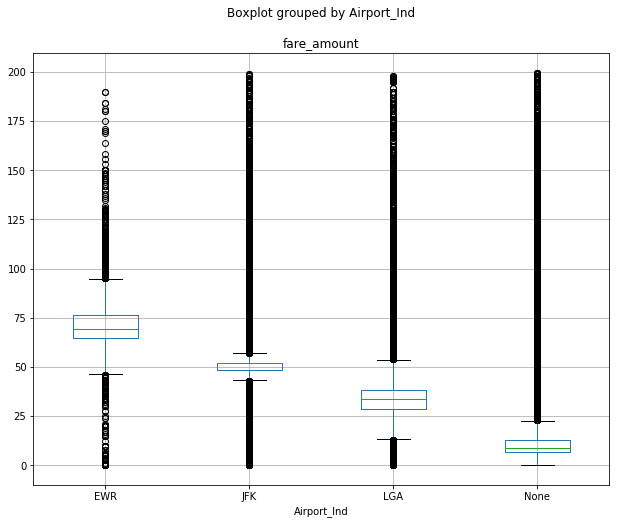

In [19]:
#filter out trips above $200 just so that I can see the boxplots easily
data_filtered=data_merged.query('fare_amount<200')
fig, ax = plt.subplots(figsize=(10,8))
data_filtered.boxplot(column=['fare_amount'], by='Airport_Ind', ax=ax)
del(data_filtered)

In [20]:
np.around(data_merged.groupby(['Airport_Ind'])['fare_amount'].describe(),0)

,count,mean,std,min,25%,50%,75%,max
Airport_Ind,,,,,,,,
EWR,19292.0,71.0,14.0,0.0,64.0,70.0,76.0,285.0
JFK,305435.0,48.0,15.0,0.0,48.0,52.0,52.0,600.0
LGA,385880.0,34.0,11.0,0.0,28.0,34.0,38.0,410.0
None,8941018.0,11.0,223.0,0.0,6.0,9.0,13.0,630462.0


Observations:
   * The airport trips generate a higher mean fare amount than trips not including pickup and dropoffs at the airports
   * Newark has the highest interquartile range for fare amount, but it appears to be less skewed than the other airport distributions. This could be due to the fact that Newark has more predetermined fares than the other two airports, which use a meter more frequently
    

Next I will explore trips with small durations (less than a minute) and high durations (more than an hour):

#### Trips with Duration Less Than One Minute

In [21]:
print("There are {} trip records with a duration less than 1 minute".format(data_merged.query('duration_min<1').shape[0]))

There are 82396 trip records with a duration less than 1 minute


In [22]:
#review data with duration less than 1 minute
low_dur=data_merged.query('duration_min<1')
low_dur=low_dur[['PULocationID','DOLocationID','Borough_PU','Borough_DO','trip_distance','duration_min','fare_amount']]
print("Example of trips with duration less than 1 minute")
low_dur.head(10)

Example of trips with duration less than 1 minute


,PULocationID,DOLocationID,Borough_PU,Borough_DO,trip_distance,duration_min,fare_amount
1,132,74,Queens,Manhattan,17.57,0.000000,52.0
2,138,249,Queens,Manhattan,13.34,0.000000,47.0
3,132,230,Queens,Manhattan,18.08,0.000000,52.0
65,138,138,Queens,Queens,1.30,0.200000,2.5
109,264,24,Unknown,Manhattan,0.00,0.050000,60.0
224,148,148,Manhattan,Manhattan,5.20,0.966667,2.5
317,48,48,Manhattan,Manhattan,0.20,0.700000,3.0
581,249,158,Manhattan,Manhattan,0.10,0.700000,2.5
731,146,146,Queens,Queens,3.70,0.050000,2.5
865,229,229,Manhattan,Manhattan,0.01,0.800000,2.5


Observations:
   * It appears that three of the ten sample trips with duration less than one minute are airport trips from JFK or LGA to Manhattan.
   * One trip has no distance and small duration, but the fare amount of $60 is quite high.
   * The fare amounts for the other six trips are the minimal trip initiation fee. This indicates that the trip was probably cancelled right upon pickup.
    

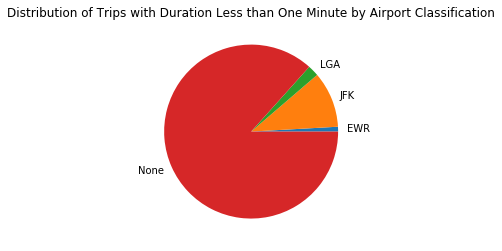

In [23]:
from matplotlib.pyplot import pie, axis, show
low_dur=data_merged.query('duration_min<1')
counts=low_dur.groupby(['Airport_Ind'])['Airport_Ind'].count()
axis('equal')
pie(counts, labels=counts.index)
plt.title('Distribution of Trips with Duration Less than One Minute by Airport Classification')
show()
del(low_dur)

#### Trips with Duration Greater Than One Hour

In [24]:
print("There are {} trip records with a duration greater than 1 hour".format(data_merged.query('duration_min>60').shape[0]))

There are 143360 trip records with a duration greater than 1 hour


In [25]:
#review data with duration greater than one hour
high_dur=data_merged.query('duration_min>60')
high_dur=high_dur[['PULocationID','DOLocationID','Borough_PU','Borough_DO','trip_distance','duration_min','fare_amount']]
print("Example of trips with duration greater than one hour")
high_dur.head(10)

Example of trips with duration greater than one hour


,PULocationID,DOLocationID,Borough_PU,Borough_DO,trip_distance,duration_min,fare_amount
70,48,24,Manhattan,Manhattan,3.33,1432.033325,11.0
120,263,79,Manhattan,Manhattan,5.09,1395.349976,20.0
302,137,226,Manhattan,Queens,0.00,134.416672,45.0
600,138,228,Queens,Brooklyn,14.00,76.466667,62.0
806,79,75,Manhattan,Manhattan,5.21,1430.266724,16.5
1418,230,141,Manhattan,Manhattan,1.84,1435.349976,8.5
1494,39,193,Brooklyn,Queens,18.08,65.000000,51.0
3182,100,14,Manhattan,Brooklyn,14.04,88.316666,64.0
3464,132,42,Queens,Manhattan,19.67,63.466667,52.0
4005,211,48,Manhattan,Manhattan,3.72,1422.266724,15.0


Observations: 
   * Out of the ten sample trips with duration greater than an hour, two are airport trips.
   * Only four trips have distances greater than 10 miles and four of the trips have fares greater than $50. These seem to be the only legitimate trips.

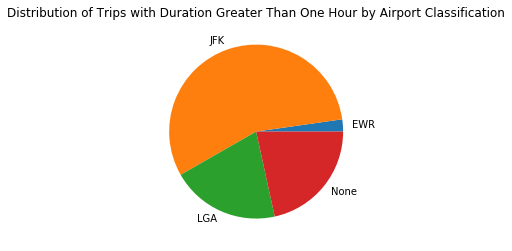

In [26]:
high_dur=data_merged.query('duration_min>60')
counts=high_dur.groupby(['Airport_Ind'])['Airport_Ind'].count()
axis('equal')
pie(counts, labels=counts.index)
plt.title('Distribution of Trips with Duration Greater Than One Hour by Airport Classification')
show()
del(high_dur)

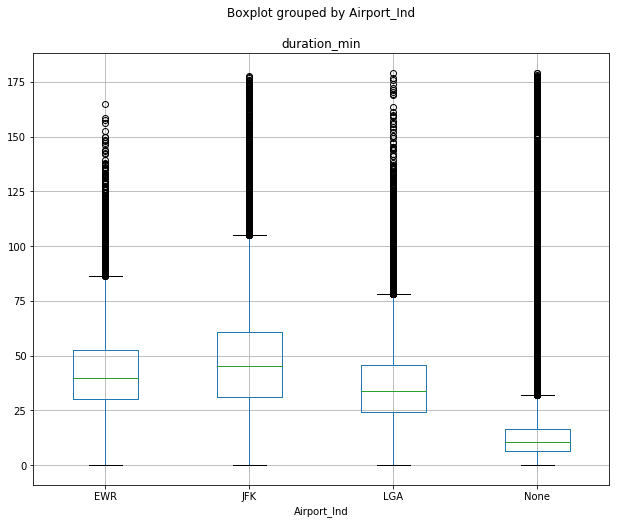

In [27]:
#Review the duration of airport trips
#filter out trips with duration above three hours just so that I can see the boxplots easily
data_filtered=data_merged.query('duration_min<180')
fig, ax = plt.subplots(figsize=(10,8))
data_filtered.boxplot(column=['duration_min'], by='Airport_Ind', ax=ax)
del(data_filtered)

In [28]:
print("Distribution of Trip Duration by Airport Classification")
np.around(data_merged.groupby(['Airport_Ind'])['duration_min'].describe(),0)

Distribution of Trip Duration by Airport Classification


,count,mean,std,min,25%,50%,75%,max
Airport_Ind,,,,,,,,
EWR,19292.0,47.0,75.0,0.0,30.0,40.0,53.0,1440.0
JFK,305435.0,49.0,65.0,0.0,31.0,45.0,61.0,1440.0
LGA,385880.0,39.0,61.0,0.0,24.0,34.0,46.0,1440.0
None,8941018.0,15.0,54.0,0.0,6.0,11.0,17.0,1440.0


In [29]:
data_merged.groupby(['Airport_Ind'])['duration_min'].quantile([0.95])

Airport_Ind      
EWR          0.95    80.140833
JFK          0.95    84.533333
LGA          0.95    64.066666
None         0.95    30.000000
Name: duration_min, dtype: float64

Observations:
   * JFK trips have the highest average duration. In fact, the 75th percentile of JFK trips are over an hour. 
   * The maximum of the JFK trips (Q3+1.5IQR) is a little over 100 minutes. The other two airports have maximums closer to 80 and 85 minutes. 
   * I calculate that the 95th percentile for trip duration is 80 minutes for EWR, 85 minutes for JFK, 65 inutes for LGA, and 30 minutes for None.
   * I will set 90 minutes as the upper limit for trip duration. All trips lasting longer than 90 minutes will be excluded. 

#### Trips with Distance of Zero Miles

In [30]:
print("There are {} trip records with a distance of 0 miles".format(data_merged.query('trip_distance==0').shape[0]))

There are 63029 trip records with a distance of 0 miles


In [31]:
#review data with zero distance
zero_dist=data_merged.query('trip_distance==0')
zero_dist=zero_dist[['PULocationID','DOLocationID','Borough_PU','Borough_DO','trip_distance','duration_min','fare_amount']]
print("Example of zero distance trips")
zero_dist.head(10)

Example of zero distance trips


,PULocationID,DOLocationID,Borough_PU,Borough_DO,trip_distance,duration_min,fare_amount
77,193,193,Queens,Queens,0.0,1.183333,45.0
109,264,24,Unknown,Manhattan,0.0,0.050000,60.0
302,137,226,Manhattan,Queens,0.0,134.416672,45.0
316,264,145,Unknown,Queens,0.0,1.366667,3.0
900,163,163,Manhattan,Manhattan,0.0,0.333333,2.5
913,132,132,Queens,Queens,0.0,0.083333,2.5
1080,162,162,Manhattan,Manhattan,0.0,0.283333,52.0
1227,265,265,Unknown,Unknown,0.0,0.100000,100.0
1263,68,68,Manhattan,Manhattan,0.0,0.083333,2.5
1450,162,162,Manhattan,Manhattan,0.0,0.866667,52.0


Observations:
   * Seven of the ten sample trips with zero distance have the same pick up and drop off locations. Two of these seven trips have known locations, small durations, and high fare rates. This points to the fact that the taxi did not record the trip correctly due to GPS error or the driver not recording the trip. 
   * There are three other trips with high fare rates and low durations. Again, the trip was not recorded correctly,
   * The rest of the trips have minimum fares, which is most likely a cancelled trip. 

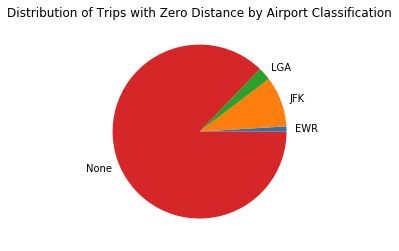

In [32]:
from matplotlib.pyplot import pie, axis, show
zero_dist=data_merged.query('trip_distance==0')
counts=zero_dist.groupby(['Airport_Ind'])['Airport_Ind'].count()
axis('equal')
pie(counts, labels=counts.index)
plt.title('Distribution of Trips with Zero Distance by Airport Classification')
show()
del(zero_dist)

#### Long Distance Trips (Greater than 25 Miles)

In [33]:
print("There are {} trip records with a distance of 25 miles".format(data_merged.query('trip_distance>25').shape[0]))

There are 11197 trip records with a distance of 25 miles


In [34]:
#review data with long distance
high_dist=data_merged.query('trip_distance>25')
high_dist=high_dist[['PULocationID','DOLocationID','Borough_PU','Borough_DO','trip_distance','duration_min','fare_amount']]
print("Example of long distance trips")
high_dist.head(10)

Example of long distance trips


,PULocationID,DOLocationID,Borough_PU,Borough_DO,trip_distance,duration_min,fare_amount
613,100,155,Manhattan,Brooklyn,25.17,44.083332,68.0
1764,132,40,Queens,Brooklyn,26.10,31.116667,68.0
1876,132,181,Queens,Brooklyn,25.64,34.183334,67.5
4239,138,265,Queens,Unknown,29.40,53.616665,117.5
5046,132,181,Queens,Brooklyn,25.81,38.500000,68.5
5082,264,264,Unknown,Unknown,25.35,39.849998,67.5
5654,132,33,Queens,Brooklyn,26.65,29.166666,69.0
5676,132,200,Queens,Bronx,27.12,34.466667,70.5
6318,132,181,Queens,Brooklyn,25.46,35.083332,68.0
8903,132,265,Queens,Unknown,35.20,41.349998,150.0


Given the high duration and fare amount, all of the example trips with long distance could be valid. I suspect most of the long distance trips are airport trips.


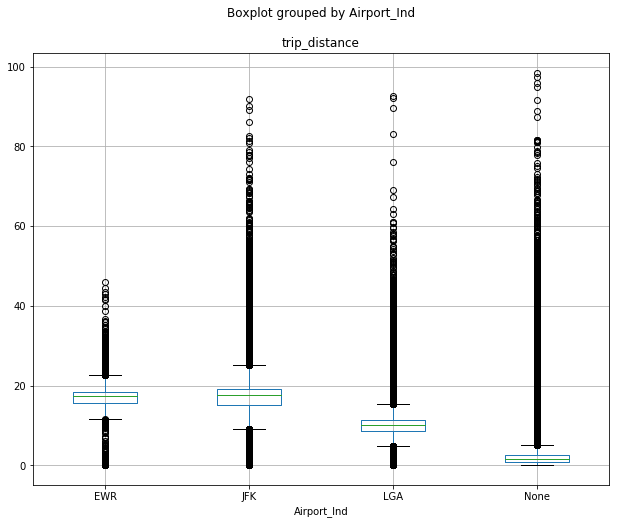

In [35]:
#Review the distance of airport trips
#filter out trips with distance more than 100 miles just so that I can see the boxplots easily
data_filtered=data_merged.query('trip_distance<100')
fig, ax = plt.subplots(figsize=(10,8))
data_filtered.boxplot(column=['trip_distance'], by='Airport_Ind', ax=ax)
del(data_filtered)

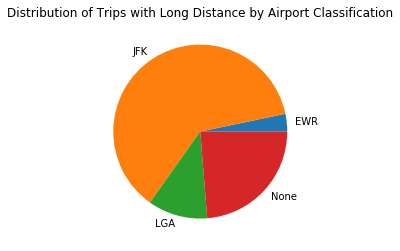

In [36]:
long_dist=data_merged.query('trip_distance>25')
counts=long_dist.groupby(['Airport_Ind'])['Airport_Ind'].count()
axis('equal')
pie(counts, labels=counts.index)
plt.title('Distribution of Trips with Long Distance by Airport Classification')
show()
del(long_dist)

In [37]:
print("Distribution of Trip Distance by Airport Classification")
np.around(data_merged.groupby(['Airport_Ind'])['trip_distance'].describe(),0)

Distribution of Trip Distance by Airport Classification


,count,mean,std,min,25%,50%,75%,max
Airport_Ind,,,,,,,,
EWR,19292.0,17.0,4.0,0.0,16.0,17.0,18.0,46.0
JFK,305435.0,16.0,6.0,0.0,15.0,18.0,19.0,248.0
LGA,385880.0,10.0,3.0,0.0,9.0,10.0,11.0,93.0
None,8941018.0,2.0,5.0,0.0,1.0,2.0,3.0,9497.0


In [38]:
data_merged.groupby(['Airport_Ind'])['trip_distance'].quantile([0.95])

Airport_Ind      
EWR          0.95    21.19
JFK          0.95    22.31
LGA          0.95    14.50
None         0.95     6.16
Name: trip_distance, dtype: float64

Observations:
 * The boxplots show that JFK has the highest max distance (Q3+1.5*IQR) of 25 miles. The other airports have box plot max distances of 22 miles and 15 miles. Trips not involving airports have a max boxplot distance of about 5 miles.
 * The 95th percentile of trip distance is 21 miles for EWR, 22 miles for JFK, 15 for LGA, and 6 miles for all other trips.
 * I will cap my distance at 50 miles.

In [39]:
df=data_merged[['Airport_Ind','fare_amount','trip_distance','duration_min']].groupby(['Airport_Ind']).quantile(0.999)
df.columns=['fare_amount','trip_distance','duration_min']
print("99.9th Percentile of Fare Amount ($), Trip Distance (mile), and Trip Duration (min) by Airport Classification")
df=np.around(df,0)
df
del(df)

99.9th Percentile of Fare Amount ($), Trip Distance (mile), and Trip Duration (min) by Airport Classification


## Remove Outlier Values

I want to remove incorrect data and outliers from my data without excluding airport trips, which exhibit extreme values when compared to trips within the boroughs. I explored the fare, duration, and distance distribution edge cases for my entire dataset and across the airport classifications (Newark, JFK, LaGuardia, and not an airport trip).

Based upon my results, I decided to use the following rules for removing outliers:
   * Remove trips with fares of \\$3 or less
   * Remove trips with a duration less than 1 minute
   * Remove trips with distance less than 0.20 mile (bottom 1 percentile for non airport trips)
   * Remove trips with fare amount greater than \\$200
   * Remove trips with a duration greater than 90 minutes
   * Remove trips with a distance greater than 50 miles
   

In [40]:
#remove bottom 1% and top 1% for duration and fare amount
#data_merged['min_duration']=data_merged['duration_min'].quantile(0.01)
#data_merged['max_duration']=data_merged['duration_min'].quantile(0.99)
#data_merged['min_fare']=data_merged['fare_amount'].quantile(0.01)
#data_merged['max_fare']=data_merged['fare_amount'].quantile(0.99)
#data_merged['min_distance']=data_merged['trip_distance'].quantile(0.01)
#data_merged['max_distance']=50 #I felt that 25 miles was too short of a distance to set as the max

#data_merged=data_merged.query('fare_amount>=min_fare and fare_amount<=max_fare and duration_min>=min_duration and duration_min<=max_duration and trip_distance>=min_distance and trip_distance<=max_distance')
#data_merged=data_merged.drop(['min_fare','max_fare','min_duration','max_duration','min_distance','max_distance'],axis=1)


In [41]:
data_merged=data_merged.query("fare_amount>3 and fare_amount<200 and duration_min>1 and duration_min<90 and trip_distance>=0.2 and trip_distance<50")

In [42]:
#review data loss
trace = go.Pie(values = [data_merged.shape[0],
                         init_row-filtered_row,
                         filtered_row - data_merged.shape[0]],
               labels = ["Available data" , "Data loss due to invalid values","Data loss due to outliers"],
               marker = dict(colors =  [ 'royalblue' ,'orange','lime'],line = dict(color = "black",
                                                                          width =  1.5)),
               rotation  = 60,
               hoverinfo = "label+percent",
              )

layout = go.Layout(dict(title = "Data Loss due to outliers and invalid values",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

fig = go.Figure(data=[trace],layout=layout)
py.iplot(fig)




## Feature Engineering for Edge Cases

My first engineered feature is the direct distance from a pickup location to a dropoff location. 
I found a shapefile containing the taxi location ids and then converted that to latitude and longitude coordinates using a tool online. I wanted to calculate the direct distance using Haversine as a way to gauge the validity of the trip distance metrics provided. I also hoped that it would give me insight about how complex a trip is. For example, a trip might be much longer in distance than the direct route due to road closures, one-way roads, tolls/gateways, etc. Since zones 264 and 265 are unknown locations, there are no coordiantes for these zones. I set the direct distance to an arbitrarily high number, 999, whenever a pickup or drop off location was unknown.

In [43]:
# Calculate the Haversine "direct distance" of each region
# if the lat and long are missing (zone 164 and 165, use lat=0 long=0)

#coordinate_data=pd.read_csv("taxi_zones_lat_long.csv")
coordinate_data=pd.read_csv("taxi_zones_lat_long.csv")
cord_data_PU=coordinate_data[['X','Y','OBJECTID']]
cord_data_PU=cord_data_PU.rename(columns={'X':'lng1','Y':'lat1','OBJECTID':'PULocationID'})
cord_data_DO=coordinate_data[['X','Y','OBJECTID']]
cord_data_DO=cord_data_DO.rename(columns={'X':'lng2','Y':'lat2','OBJECTID':'DOLocationID'})
data_merged=pd.merge(data_merged,cord_data_PU,how='left',on=['PULocationID'])
data_merged=pd.merge(data_merged,cord_data_DO,how='left',on=['DOLocationID'])
data_merged['lat1'].fillna(0,inplace=True)
data_merged['lat2'].fillna(0,inplace=True)
data_merged['lng1'].fillna(0,inplace=True)
data_merged['lng2'].fillna(0,inplace=True)


In [44]:
    lat1 = data_merged['lat1']
    lat2 = data_merged['lat2']
    lng1 = data_merged['lng1']
    lng2 = data_merged['lng2']    
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    h = h/0.621371  #convert to miles
    
    data_merged['direct_distance']=h
    
#change direct distance to 999 if the coordinates are not known
mask_0 = ((data_merged.PULocationID == 264)|(data_merged.DOLocationID==264))
mask_1 = ((data_merged.PULocationID == 265)|(data_merged.DOLocationID==265))
data_merged.loc[mask_0, 'direct_distance'] = 999
data_merged.loc[mask_1, 'direct_distance'] = 999

I had already filtered out fare amounts, distance, and durations that were invalid or extreme. Even though a measure can be valid in a univarite setting, it may be incorrect when compared to the other attribute values assigned to a trip. For example, a trip trip duration of ten minutes is reasonable for a short trip in Manhattan and 20 miles is a typical drip length for a taxi leaving the airport, but traveling 20 miles in 10 minutes results in a trip speed of 120 mph.
In order to flag erroneous combinations of data for imputation or exclusion, I calculated the speed of the taxi and the rate (dollars per minute) for each trip.

In [45]:
#calculate the speed of the driver
data_merged['speed_mph']=data_merged['trip_distance']/(data_merged['duration_min']/60)

#calculate the driver efficiency - fare/min
data_merged['dollar_per_min']=data_merged['fare_amount']/data_merged['duration_min']

#indicator for rain
#data_merged['rain_ind']=np.where(data_merged['precip_inch']>0.01,1,0)


In [46]:
#review statistics of the speed
data_merged['speed_mph'].quantile([0,0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.99,0.995,0.999,1])

0.000       0.134028
0.010       3.018868
0.050       4.467780
0.100       5.431034
0.250       7.362610
0.500      10.024213
0.750      13.592677
0.900      18.495183
0.950      22.623398
0.990      32.298776
0.995      36.276391
0.999      43.527849
1.000    1788.196789
Name: speed_mph, dtype: float64

In [47]:
#review statistics of the dollars per min
data_merged['dollar_per_min'].quantile([0,0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.99,0.995,0.999,1])

0.000      0.050261
0.010      0.603908
0.050      0.651214
0.100      0.686456
0.250      0.766423
0.500      0.890944
0.750      1.068249
0.900      1.304348
0.950      1.499111
0.990      2.000000
0.995      2.262509
0.999      3.037975
1.000    179.999993
Name: dollar_per_min, dtype: float64

Observations:
 * The NYC.gov speed limit website (https://www1.nyc.gov/html/dot/downloads/pdf/current-pre-vision-zero-speed-limit-maps.pdf) shows that most roads in the boroughs have a speed limit of 25 mph or 30 mph. Some of the roads around the perimeter of the boroughs have a speed limit of 50 mph. (FDR has a speed limit of 40 mph). 
 * Due to the posted speed limits and presence of heavy congestion in NYC, having a taxi speed above 50 mph seems incorrect.
 * Drivers make 50 cents per 1/5 mile driven or per minute of slow travel/stopping. This is doubled when outside of NYC. A rate of \\$2/min equates to 4/5 file per minute = 48 mph. A fare of \\$2.5/min equares to 1 mile per minute = 60 mph
 * Unusual rates could be due to negotiated fee trips

I will review records with speeds below 3 mph, speeds above 50 mph, rates below \\$0.50, and rates above \\$3

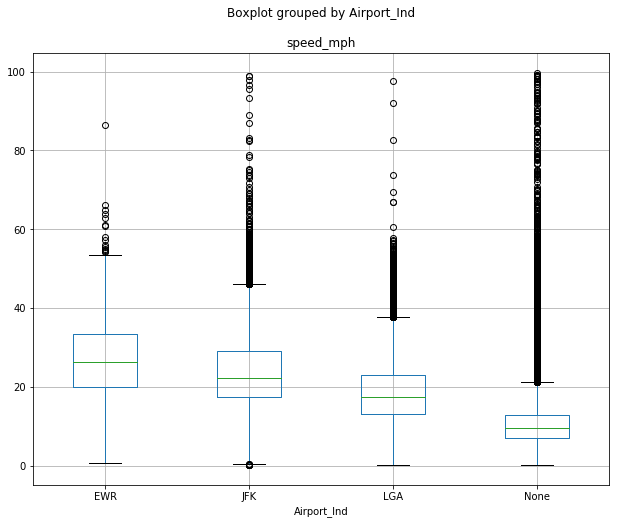

In [48]:
#Review the speed of airport trips vs non airport trips
# drop records with over 100 mph so that I can view the box plots
data_filtered=data_merged.query('speed_mph<100')
fig, ax = plt.subplots(figsize=(10,8))
data_filtered.boxplot(column=['speed_mph'], by='Airport_Ind', ax=ax)
del(data_filtered)

#### High Speed Trips

In [49]:
#review high speeds
df=data_merged.query('speed_mph>50')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['speed_mph'],ascending=False)
print("Bottom Ten Trips for Speed (mph)")
df.head(10)



Bottom Ten Trips for Speed (mph)


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
701994,265,Unknown,unknown,265,Unknown,unknown,2017-06-03 01:14:29,2017-06-03 01:15:30,1.016667,30.30,999.0,40.00,1788.196789,39.344263
2480458,265,Unknown,unknown,265,Unknown,unknown,2017-06-08 17:09:02,2017-06-08 17:10:19,1.283333,35.80,999.0,179.06,1673.766275,139.527276
2632508,132,Queens,JFK Airport,132,Queens,JFK Airport,2017-06-09 00:56:09,2017-06-09 00:57:29,1.333333,36.56,0.0,120.00,1645.199960,89.999997
8181195,265,Unknown,unknown,265,Unknown,unknown,2017-06-26 19:16:00,2017-06-26 19:17:05,1.083333,28.10,999.0,195.00,1556.307625,179.999993
7951759,265,Unknown,unknown,265,Unknown,unknown,2017-06-25 22:21:10,2017-06-25 22:22:36,1.433333,35.10,999.0,128.00,1469.302390,89.302329
8909551,265,Unknown,unknown,265,Unknown,unknown,2017-06-29 06:14:12,2017-06-29 06:15:23,1.183333,28.20,999.0,130.00,1429.859213,109.859160
479514,265,Unknown,unknown,265,Unknown,unknown,2017-06-02 12:57:58,2017-06-02 12:59:07,1.150000,26.80,999.0,106.00,1398.260844,92.173915
8829696,265,Unknown,unknown,265,Unknown,unknown,2017-06-28 21:14:02,2017-06-28 21:15:05,1.050000,24.20,999.0,119.99,1382.857137,114.276196
7846562,265,Unknown,unknown,265,Unknown,unknown,2017-06-25 13:03:43,2017-06-25 13:04:49,1.100000,22.60,999.0,98.00,1232.727196,89.090907
7940526,265,Unknown,unknown,265,Unknown,unknown,2017-06-25 21:17:56,2017-06-25 21:19:17,1.350000,27.70,999.0,125.00,1231.111062,92.592591


The top ten trips for high speed all have unknown drop off locations and all but one have unknown pickup locations. The trips have longer distances (22 to 37 miles), but durations close to 1 minutes. I believe that this is due to an error in the meter or an error with taxi driver's input. I would need to impute the duration values to fix the speed, but this introduces a high level of uncertainty since the locations could be spread out across NYC.

I did notice that many of the trips with speeds around 50 mph were airport trips. I need to analyze the speed limit threshold across the airport classifications. It makes sense for an airport trip to have a higher speed due to the taxis traveling on highways and perimeter roads with less intersections. 

In [50]:
print("Distribution of Trip Speed by Airport Classification")
np.around(data_merged.groupby(['Airport_Ind'])['speed_mph'].describe(),0)

Distribution of Trip Speed by Airport Classification


,count,mean,std,min,25%,50%,75%,max
Airport_Ind,,,,,,,,
EWR,17899.0,27.0,12.0,1.0,20.0,26.0,33.0,788.0
JFK,285774.0,24.0,11.0,0.0,18.0,22.0,29.0,1645.0
LGA,381334.0,19.0,8.0,0.0,13.0,17.0,23.0,793.0
None,8798287.0,11.0,6.0,0.0,7.0,10.0,13.0,1788.0


In [51]:
data_merged.groupby(['Airport_Ind'])['speed_mph'].quantile([0.995])

Airport_Ind       
EWR          0.995    48.648023
JFK          0.995    48.177541
LGA          0.995    40.790472
None         0.995    29.608825
Name: speed_mph, dtype: float64

The airport trips have a much higher speed than those trips not to the airport. I want to review those trips with high speeds that are not going to the airport. 

In [52]:
df=data_merged.query('speed_mph>50 and Airport_Ind=="None"')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['speed_mph'],ascending=False)
print("Top Ten Fastest No Airport Trips With A Speed Greater than 50 mph")                    
df.head(10)

Top Ten Fastest No Airport Trips With A Speed Greater than 50 mph


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
701994,265,Unknown,unknown,265,Unknown,unknown,2017-06-03 01:14:29,2017-06-03 01:15:30,1.016667,30.3,999.0,40.00,1788.196789,39.344263
2480458,265,Unknown,unknown,265,Unknown,unknown,2017-06-08 17:09:02,2017-06-08 17:10:19,1.283333,35.8,999.0,179.06,1673.766275,139.527276
8181195,265,Unknown,unknown,265,Unknown,unknown,2017-06-26 19:16:00,2017-06-26 19:17:05,1.083333,28.1,999.0,195.00,1556.307625,179.999993
7951759,265,Unknown,unknown,265,Unknown,unknown,2017-06-25 22:21:10,2017-06-25 22:22:36,1.433333,35.1,999.0,128.00,1469.302390,89.302329
8909551,265,Unknown,unknown,265,Unknown,unknown,2017-06-29 06:14:12,2017-06-29 06:15:23,1.183333,28.2,999.0,130.00,1429.859213,109.859160
479514,265,Unknown,unknown,265,Unknown,unknown,2017-06-02 12:57:58,2017-06-02 12:59:07,1.150000,26.8,999.0,106.00,1398.260844,92.173915
8829696,265,Unknown,unknown,265,Unknown,unknown,2017-06-28 21:14:02,2017-06-28 21:15:05,1.050000,24.2,999.0,119.99,1382.857137,114.276196
7846562,265,Unknown,unknown,265,Unknown,unknown,2017-06-25 13:03:43,2017-06-25 13:04:49,1.100000,22.6,999.0,98.00,1232.727196,89.090907
7940526,265,Unknown,unknown,265,Unknown,unknown,2017-06-25 21:17:56,2017-06-25 21:19:17,1.350000,27.7,999.0,125.00,1231.111062,92.592591
4894235,265,Unknown,unknown,265,Unknown,unknown,2017-06-16 00:34:43,2017-06-16 00:35:45,1.033333,20.7,999.0,106.50,1201.935504,103.064519


In [53]:
df=data_merged.query('speed_mph>50 and Airport_Ind=="None"')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['speed_mph'],ascending=True)
print("Bottom Ten Slowest No Airport Trips With A Speed Greater than 50 mph")                    
df.head(10)

Bottom Ten Slowest No Airport Trips With A Speed Greater than 50 mph


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
6120493,264,Unknown,NV,264,Unknown,NV,2017-06-20 03:35:20,2017-06-20 03:51:24,16.066668,13.39,999.000000,36.0,50.004145,2.240664
7803631,74,Manhattan,East Harlem North,216,Queens,South Ozone Park,2017-06-25 09:04:00,2017-06-25 09:20:54,16.900000,14.10,27.996801,52.0,50.059172,3.076923
187288,124,Queens,Howard Beach,219,Queens,Springfield Gardens South,2017-06-01 16:24:25,2017-06-01 16:26:56,2.516667,2.10,12.081978,7.5,50.066225,2.980132
7109724,48,Manhattan,Clinton East,265,Unknown,unknown,2017-06-23 04:02:15,2017-06-23 04:51:48,49.549999,41.35,999.000000,180.0,50.070636,3.632694
1598088,14,Brooklyn,Bay Ridge,219,Queens,Springfield Gardens South,2017-06-05 23:30:07,2017-06-05 23:56:00,25.883333,21.60,37.169357,56.5,50.070831,2.182872
7787856,230,Manhattan,Times Sq/Theatre District,265,Unknown,unknown,2017-06-25 05:49:59,2017-06-25 06:33:53,43.900002,36.64,999.000000,146.0,50.077448,3.325740
1949344,163,Manhattan,Midtown North,265,Unknown,unknown,2017-06-07 01:16:26,2017-06-07 02:12:37,56.183334,46.90,999.000000,150.0,50.086027,2.669831
8918556,93,Queens,Flushing Meadows-Corona Park,93,Queens,Flushing Meadows-Corona Park,2017-06-29 07:09:14,2017-06-29 07:11:52,2.633333,2.20,0.000000,8.0,50.126582,3.037975
1433604,70,Queens,East Elmhurst,265,Unknown,unknown,2017-06-05 13:50:49,2017-06-05 14:15:57,25.133333,21.00,999.000000,100.0,50.132625,3.978780
2021154,50,Manhattan,Clinton West,265,Unknown,unknown,2017-06-07 09:52:33,2017-06-07 10:29:40,37.116665,31.02,999.000000,80.5,50.144590,2.168837


I debated applying a different speed outlier threshold to airport trips vs nonairport trips. After reviewing the high speed trips (speed>50mph) for non airport trips, I determined that the duration values are wrong for trips with extreme speeds and cannot be properly imputed due to the high occurance of unknown pickup and dropoff locations. The non airport trips that have speeds of approximately 50 mph have relatively appropriate duration, distance, and speed combinations. I will apply the same speed outlier filter for all trips, regardless of airport classification. I will drop all trips with a speed greater than 65 mph.

####  Trips with Low Speed 

In [54]:
df=data_merged.query('speed_mph<3')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['speed_mph'])
print("Slowest 10 Trips")
df.head(10)



Slowest 10 Trips


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
9271057,161,Manhattan,Midtown Center,161,Manhattan,Midtown Center,2017-06-30 09:57:23,2017-06-30 11:26:55,89.533333,0.20,0.000000,4.5,0.134028,0.050261
2123741,211,Manhattan,SoHo,144,Manhattan,Little Italy/NoLiTa,2017-06-07 16:06:51,2017-06-07 17:32:01,85.166664,0.20,0.801303,45.0,0.140900,0.528376
2810254,132,Queens,JFK Airport,79,Manhattan,East Village,2017-06-09 16:02:14,2017-06-09 17:11:53,69.650002,0.20,31.966752,52.0,0.172290,0.746590
5786236,230,Manhattan,Times Sq/Theatre District,100,Manhattan,Garment District,2017-06-18 22:03:38,2017-06-18 23:06:37,62.983334,0.20,1.293779,34.0,0.190527,0.539825
6216529,140,Manhattan,Lenox Hill East,140,Manhattan,Lenox Hill East,2017-06-20 12:09:01,2017-06-20 13:28:59,79.966667,0.26,0.000000,37.5,0.195081,0.468945
927523,132,Queens,JFK Airport,97,Brooklyn,Fort Greene,2017-06-03 19:11:02,2017-06-03 20:12:19,61.283333,0.20,28.126947,33.0,0.195812,0.538482
8272526,162,Manhattan,Midtown East,170,Manhattan,Murray Hill,2017-06-27 05:50:12,2017-06-27 06:46:40,56.466667,0.20,1.763758,30.5,0.212515,0.540142
6880803,164,Manhattan,Midtown South,70,Queens,East Elmhurst,2017-06-22 13:12:40,2017-06-22 14:34:10,81.500000,0.31,16.159842,45.0,0.228221,0.552147
3758303,25,Brooklyn,Boerum Hill,132,Queens,JFK Airport,2017-06-12 17:20:50,2017-06-12 18:35:06,74.266670,0.30,29.290158,4.0,0.242370,0.053860
4311987,170,Manhattan,Murray Hill,48,Manhattan,Clinton East,2017-06-14 11:25:17,2017-06-14 12:18:01,52.733334,0.23,3.142386,4.5,0.261694,0.085335


Observations: 
   * All of these trips have very high durations, very low distances, and high fare amounts. All three metrics are inconsistent. They also have very low rates (dollar per minute). The trips tend to occur in Manhattan. 
   * The direct distance (Haversine calculation) validates that several of these trips have long distances. Imputing the distance will fix the mph.
   * The direct distance also indicates that several of the trips have short distances between pickup and drop off locations. That means that either the location ids are wrong or the duration and fare amounts are wrong. I am unable to validate if the issue occurs with the locationIds, so I will not impute. 

In [55]:
df=data_merged.query('speed_mph<1')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['speed_mph'],ascending=False)
print("Sample of Trips with a speed of 1 mph")
df.head(10)

Sample of Trips with a speed of 1 mph


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
5350046,48,Manhattan,Clinton East,100,Manhattan,Garment District,2017-06-17 12:30:05,2017-06-17 12:42:05,12.000000,0.20,1.567664,8.5,1.000000,0.708333
5387985,234,Manhattan,Union Sq,90,Manhattan,Flatiron,2017-06-17 14:26:18,2017-06-17 14:38:18,12.000000,0.20,0.942993,8.0,1.000000,0.666667
9065532,48,Manhattan,Clinton East,48,Manhattan,Clinton East,2017-06-29 16:55:35,2017-06-29 17:07:35,12.000000,0.20,0.000000,8.5,1.000000,0.708333
4769692,230,Manhattan,Times Sq/Theatre District,230,Manhattan,Times Sq/Theatre District,2017-06-15 18:21:09,2017-06-15 18:39:09,18.000000,0.30,0.000000,11.5,1.000000,0.638889
5378194,230,Manhattan,Times Sq/Theatre District,100,Manhattan,Garment District,2017-06-17 13:52:58,2017-06-17 14:04:59,12.016666,0.20,1.293779,8.0,0.998613,0.665742
7328046,100,Manhattan,Garment District,230,Manhattan,Times Sq/Theatre District,2017-06-23 19:31:02,2017-06-23 19:55:04,24.033333,0.40,1.293779,14.5,0.998613,0.603329
9080828,100,Manhattan,Garment District,100,Manhattan,Garment District,2017-06-29 18:00:36,2017-06-29 18:16:51,16.250000,0.27,0.000000,10.5,0.996923,0.646154
9007545,234,Manhattan,Union Sq,164,Manhattan,Midtown South,2017-06-29 13:01:20,2017-06-29 13:17:35,16.250000,0.27,1.640392,10.5,0.996923,0.646154
8989905,234,Manhattan,Union Sq,186,Manhattan,Penn Station/Madison Sq West,2017-06-29 11:52:04,2017-06-29 12:08:56,16.866667,0.28,1.485164,10.5,0.996047,0.622530
5099503,231,Manhattan,TriBeCa/Civic Center,211,Manhattan,SoHo,2017-06-16 17:27:14,2017-06-16 17:43:30,16.266666,0.27,1.179394,10.5,0.995902,0.645492


In [56]:
df=data_merged.query('speed_mph<2')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['speed_mph'],ascending=False)
print("Sample of Trips with a speed of 2 mph")
df.head(10)

Sample of Trips with a speed of 2 mph


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
4291451,113,Manhattan,Greenwich Village North,113,Manhattan,Greenwich Village North,2017-06-14 10:14:04,2017-06-14 10:22:28,8.4,0.28,0.000000,6.5,2.0,0.773810
6570587,229,Manhattan,Sutton Place/Turtle Bay North,161,Manhattan,Midtown Center,2017-06-21 14:19:51,2017-06-21 14:30:03,10.2,0.34,1.687178,7.0,2.0,0.686275
4679335,50,Manhattan,Clinton West,48,Manhattan,Clinton East,2017-06-15 12:52:58,2017-06-15 13:04:04,11.1,0.37,0.967464,8.0,2.0,0.720721
9294540,68,Manhattan,East Chelsea,68,Manhattan,East Chelsea,2017-06-30 11:43:54,2017-06-30 11:49:54,6.0,0.20,0.000000,5.0,2.0,0.833333
8383989,186,Manhattan,Penn Station/Madison Sq West,230,Manhattan,Times Sq/Theatre District,2017-06-27 13:18:32,2017-06-27 13:42:32,24.0,0.80,2.323423,14.5,2.0,0.604167
7859927,161,Manhattan,Midtown Center,164,Manhattan,Midtown South,2017-06-25 14:12:13,2017-06-25 14:18:13,6.0,0.20,2.041490,5.5,2.0,0.916667
9105108,90,Manhattan,Flatiron,186,Manhattan,Penn Station/Madison Sq West,2017-06-29 19:23:15,2017-06-29 19:35:15,12.0,0.40,1.212252,8.5,2.0,0.708333
1723442,141,Manhattan,Lenox Hill West,161,Manhattan,Midtown Center,2017-06-06 12:14:26,2017-06-06 12:38:26,24.0,0.80,2.853651,14.5,2.0,0.604167
5919018,249,Manhattan,West Village,114,Manhattan,Greenwich Village South,2017-06-19 12:33:00,2017-06-19 12:39:00,6.0,0.20,1.192043,5.5,2.0,0.916667
5106337,230,Manhattan,Times Sq/Theatre District,163,Manhattan,Midtown North,2017-06-16 17:49:32,2017-06-16 17:55:32,6.0,0.20,1.136629,5.5,2.0,0.916667


After reviewing the slow trips at approximately 0 mph, 1 mph, and 2 mph, I have concluded that the data begins to look reasonable at 1 mph. Most of the trips at speeds around 1 mph are short trips within Manhattan.I will drop all records that have speeds less than 1 mph.


#### Trips with High Rates

In [57]:
df=data_merged.query('dollar_per_min>3')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['dollar_per_min'],ascending=True)
print("Trips with Rate of $3/Min")
df.head(10)

Trips with Rate of $3/Min


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
3894076,113,Manhattan,Greenwich Village North,144,Manhattan,Little Italy/NoLiTa,2017-06-13 06:23:03,2017-06-13 06:24:43,1.666667,1.03,2.163388,5.0,37.080000,3.0
1305886,164,Manhattan,Midtown South,265,Unknown,unknown,2017-06-05 00:14:29,2017-06-05 00:27:49,13.333333,4.05,999.000000,40.0,18.225000,3.0
6300414,151,Manhattan,Manhattan Valley,24,Manhattan,Bloomingdale,2017-06-20 17:29:32,2017-06-20 17:30:42,1.166667,0.42,0.804974,3.5,21.600001,3.0
7411368,237,Manhattan,Upper East Side South,162,Manhattan,Midtown East,2017-06-23 23:55:50,2017-06-23 23:57:00,1.166667,0.40,2.273374,3.5,20.571430,3.0
8055142,262,Manhattan,Yorkville East,262,Manhattan,Yorkville East,2017-06-26 10:58:56,2017-06-26 11:00:06,1.166667,0.40,0.000000,3.5,20.571430,3.0
1955816,263,Manhattan,Yorkville West,141,Manhattan,Lenox Hill West,2017-06-07 03:14:17,2017-06-07 03:15:27,1.166667,0.47,2.383267,3.5,24.171430,3.0
5340537,237,Manhattan,Upper East Side South,141,Manhattan,Lenox Hill West,2017-06-17 12:05:36,2017-06-17 12:06:46,1.166667,0.46,0.865730,3.5,23.657144,3.0
8013963,7,Queens,Astoria,7,Queens,Astoria,2017-06-26 08:08:41,2017-06-26 08:09:51,1.166667,0.40,0.000000,3.5,20.571430,3.0
5404840,262,Manhattan,Yorkville East,140,Manhattan,Lenox Hill East,2017-06-17 15:43:41,2017-06-17 15:44:51,1.166667,0.35,2.301433,3.5,18.000001,3.0
5413182,142,Manhattan,Lincoln Square East,239,Manhattan,Upper West Side South,2017-06-17 16:20:27,2017-06-17 16:21:37,1.166667,0.40,1.872619,3.5,20.571430,3.0


In [58]:
df=data_merged.query('dollar_per_min>3.5')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['dollar_per_min'],ascending=True)
print("Trips with Rate of $3.5/Min")
df.head(10)

Trips with Rate of $3.5/Min


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
599200,138,Queens,LaGuardia Airport,265,Unknown,unknown,2017-06-02 19:52:32,2017-06-02 20:19:40,27.133333,17.50,999.000000,95.0,38.697788,3.501229
7405128,145,Queens,Long Island City/Hunters Point,234,Manhattan,Union Sq,2017-06-23 23:34:18,2017-06-23 23:49:09,14.850000,2.80,5.774618,52.0,11.313131,3.501683
8721160,48,Manhattan,Clinton East,229,Manhattan,Sutton Place/Turtle Bay North,2017-06-28 14:38:11,2017-06-28 14:53:02,14.850000,1.25,3.494958,52.0,5.050505,3.501683
8498024,230,Manhattan,Times Sq/Theatre District,14,Brooklyn,Bay Ridge,2017-06-27 19:58:40,2017-06-27 20:15:22,16.700001,15.95,25.179226,58.5,57.305389,3.502994
6101282,90,Manhattan,Flatiron,265,Unknown,unknown,2017-06-19 23:20:42,2017-06-19 23:36:24,15.700000,6.09,999.000000,55.0,23.273886,3.503185
4339864,236,Manhattan,Upper East Side North,236,Manhattan,Upper East Side North,2017-06-14 12:57:21,2017-06-14 12:59:38,2.283333,0.99,0.000000,8.0,26.014600,3.503650
7989482,246,Manhattan,West Chelsea/Hudson Yards,265,Unknown,unknown,2017-06-26 05:40:37,2017-06-26 05:57:44,17.116667,11.20,999.000000,60.0,39.259980,3.505355
6746515,246,Manhattan,West Chelsea/Hudson Yards,265,Unknown,unknown,2017-06-22 00:02:07,2017-06-22 00:21:48,19.683332,9.96,999.000000,69.0,30.360714,3.505504
3667694,144,Manhattan,Little Italy/NoLiTa,125,Manhattan,Hudson Sq,2017-06-12 11:46:18,2017-06-12 12:01:08,14.833333,1.50,1.578478,52.0,6.067416,3.505618
9061395,74,Manhattan,East Harlem North,151,Manhattan,Manhattan Valley,2017-06-29 16:35:09,2017-06-29 16:49:59,14.833333,2.40,4.226697,52.0,9.707865,3.505618


In [59]:
df=data_merged.query('dollar_per_min>4')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['dollar_per_min'],ascending=True)
print("Trips with Rate of $4/Min")
df.head(10)

Trips with Rate of $4/Min


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
4715919,15,Queens,Bay Terrace/Fort Totten,265,Unknown,unknown,2017-06-15 15:01:47,2017-06-15 15:38:01,36.233334,16.20,999.000000,145.0,26.826128,4.001840
5174478,48,Manhattan,Clinton East,265,Unknown,unknown,2017-06-16 21:24:11,2017-06-16 22:00:25,36.233334,25.20,999.000000,145.0,41.729532,4.001840
3000747,90,Manhattan,Flatiron,265,Unknown,unknown,2017-06-10 02:59:45,2017-06-10 03:14:44,14.983334,5.40,999.000000,60.0,21.624026,4.004449
5813612,264,Unknown,NV,264,Unknown,NV,2017-06-19 01:11:45,2017-06-19 01:39:13,27.466667,23.28,999.000000,110.0,50.854367,4.004854
3888881,157,Queens,Maspeth,132,Queens,JFK Airport,2017-06-13 05:13:03,2017-06-13 05:26:02,12.983334,11.26,22.225640,52.0,52.035942,4.005135
9425421,132,Queens,JFK Airport,130,Queens,Jamaica,2017-06-30 20:04:07,2017-06-30 20:17:06,12.983334,5.40,11.262984,52.0,24.955070,4.005135
7012202,70,Queens,East Elmhurst,265,Unknown,unknown,2017-06-22 20:41:28,2017-06-22 21:12:10,30.700001,22.20,999.000000,123.0,43.387623,4.006515
5425446,142,Manhattan,Lincoln Square East,265,Unknown,unknown,2017-06-17 17:12:41,2017-06-17 17:40:38,27.950001,16.10,999.000000,112.0,34.561717,4.007156
7770609,186,Manhattan,Penn Station/Madison Sq West,265,Unknown,unknown,2017-06-25 03:08:18,2017-06-25 03:38:14,29.933332,24.49,999.000000,120.0,49.089088,4.008909
6125544,209,Manhattan,Seaport,1,EWR,Newark Airport,2017-06-20 05:56:08,2017-06-20 06:17:20,21.200001,13.49,23.906879,85.0,38.179243,4.009434


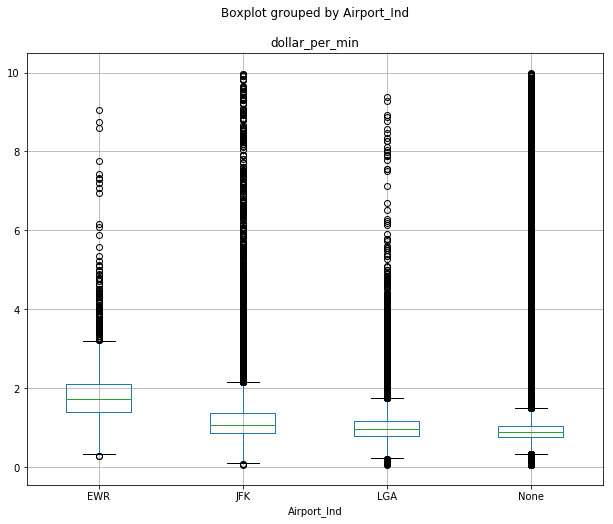

In [60]:
#Review the fare rate of airport trips vs non airport trips
# drop records with fare rate greater than $10/min so that I can view the box plots
data_filtered=data_merged.query('dollar_per_min<10')
fig, ax = plt.subplots(figsize=(10,8))
data_filtered.boxplot(column=['dollar_per_min'], by='Airport_Ind', ax=ax)
del(data_filtered)

Observations: 
   * The duration, fare amount, and distance metrics for trips with a rate of \\$3/min look reasonable. It is surprising that nine of the ten trips have the same duration. The trips are all short and quick.
   * The duration and distance metrics for trips with a rate of \\$3.50 seem intuitive, but there may be an issue with several of the fare amounts. For example, out of the sample of ten trips, four trips have short duration and distance, but a fare of \\$52. This leads me to believe that the taxi was charging a flat fare for these trips instead of using the meter.
   * Most of the sample trips with fare rates of $4.00/min have unknown pickup/dropoff locations. The fare amounts are unusually high. Out of the sample trips, only the airport trips appear to have correct data. The boxplot of fare rates by airport classification coorborates that the airport trips tend to have a higher earning rate. 
   * I will cap the earning rate to \\$3.50 for all non airport trips and \\$4 for airport trips
    
    

#### Trips with Low Rates

In [61]:
df=data_merged.query('dollar_per_min<0.50')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['dollar_per_min'],ascending=True)
print("Trips with Low Rates")
df.head(10)

Trips with Low Rates


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
9271057,161,Manhattan,Midtown Center,161,Manhattan,Midtown Center,2017-06-30 09:57:23,2017-06-30 11:26:55,89.533333,0.20,0.000000,4.5,0.134028,0.050261
6580862,138,Queens,LaGuardia Airport,170,Manhattan,Murray Hill,2017-06-21 14:56:37,2017-06-21 16:05:45,69.133331,0.58,14.931754,3.5,0.503375,0.050627
31708,107,Manhattan,Gramercy,170,Manhattan,Murray Hill,2017-06-01 06:56:34,2017-06-01 08:15:21,78.783333,0.61,2.036365,4.0,0.464565,0.050772
5868852,142,Manhattan,Lincoln Square East,193,Queens,Queensbridge/Ravenswood,2017-06-19 09:11:11,2017-06-19 10:39:21,88.166664,0.98,5.977388,4.5,0.666919,0.051040
3758303,25,Brooklyn,Boerum Hill,132,Queens,JFK Airport,2017-06-12 17:20:50,2017-06-12 18:35:06,74.266670,0.30,29.290158,4.0,0.242370,0.053860
8147168,264,Unknown,NV,142,Manhattan,Lincoln Square East,2017-06-26 17:21:50,2017-06-26 18:39:57,78.116669,0.51,999.000000,4.5,0.391722,0.057606
8120169,100,Manhattan,Garment District,186,Manhattan,Penn Station/Madison Sq West,2017-06-26 15:29:09,2017-06-26 16:27:50,58.683334,0.50,1.029645,3.5,0.511218,0.059642
9270892,161,Manhattan,Midtown Center,161,Manhattan,Midtown Center,2017-06-30 09:56:45,2017-06-30 11:12:01,75.266670,17.50,0.000000,4.5,13.950398,0.059787
5502905,79,Manhattan,East Village,224,Manhattan,Stuy Town/Peter Cooper Village,2017-06-17 22:06:02,2017-06-17 23:06:00,59.966667,0.71,1.207444,4.0,0.710395,0.066704
3554679,68,Manhattan,East Chelsea,68,Manhattan,East Chelsea,2017-06-11 22:54:22,2017-06-12 00:00:00,65.633331,0.87,0.000000,4.5,0.795328,0.068563


In [62]:
df=data_merged.query('dollar_per_min<0.50')
df=df[['PULocationID','Borough_PU','Zone_PU','DOLocationID','Borough_DO','Zone_DO','PU_time','DO_time',
       'duration_min','trip_distance','direct_distance','fare_amount','speed_mph','dollar_per_min']]
df=df.sort_values(by=['dollar_per_min'],ascending=False)
print("Trips with Low Rates")
df.head(10)

Trips with Low Rates


,PULocationID,Borough_PU,Zone_PU,DOLocationID,Borough_DO,Zone_DO,PU_time,DO_time,duration_min,trip_distance,direct_distance,fare_amount,speed_mph,dollar_per_min
3716711,186,Manhattan,Penn Station/Madison Sq West,87,Manhattan,Financial District North,2017-06-12 14:50:10,2017-06-12 15:32:11,42.016666,5.50,7.767534,21.0,7.854027,0.499802
6925208,233,Manhattan,UN/Turtle Bay South,186,Manhattan,Penn Station/Madison Sq West,2017-06-22 15:54:18,2017-06-22 16:25:19,31.016666,1.49,2.876678,15.5,2.882321,0.499731
2424905,68,Manhattan,East Chelsea,161,Manhattan,Midtown Center,2017-06-08 13:47:22,2017-06-08 14:16:23,29.016666,2.40,3.521923,14.5,4.962665,0.499713
68679,48,Manhattan,Clinton East,68,Manhattan,East Chelsea,2017-06-01 09:08:31,2017-06-01 09:37:32,29.016666,1.85,2.828764,14.5,3.825388,0.499713
529131,88,Manhattan,Financial District South,231,Manhattan,TriBeCa/Civic Center,2017-06-02 16:01:17,2017-06-02 16:28:18,27.016666,1.38,2.808356,13.5,3.064775,0.499692
7269579,261,Manhattan,World Trade Center,13,Manhattan,Battery Park City,2017-06-23 16:12:33,2017-06-23 16:37:34,25.016666,1.20,0.641129,12.5,2.878081,0.499667
4298824,230,Manhattan,Times Sq/Theatre District,233,Manhattan,UN/Turtle Bay South,2017-06-14 10:40:27,2017-06-14 11:03:28,23.016666,1.10,2.591360,11.5,2.867487,0.499638
3215850,161,Manhattan,Midtown Center,50,Manhattan,Clinton West,2017-06-10 19:50:14,2017-06-10 20:13:15,23.016666,1.56,2.697621,11.5,4.066618,0.499638
8033324,7,Queens,Astoria,193,Queens,Queensbridge/Ravenswood,2017-06-26 09:25:12,2017-06-26 09:47:13,22.016666,3.10,2.550214,11.0,8.448146,0.499622
1494756,138,Queens,LaGuardia Airport,129,Queens,Jackson Heights,2017-06-05 17:40:56,2017-06-05 18:02:57,22.016666,2.47,3.452730,11.0,6.731264,0.499622


In [63]:
print("Bottom 0.5% and 1% Fare Rate (Dollar per Minute) by Airport Classification")
data_merged.groupby(['Airport_Ind'])['dollar_per_min'].quantile([0.005,0.01])

Bottom 0.5% and 1% Fare Rate (Dollar per Minute) by Airport Classification


Airport_Ind       
EWR          0.005    0.964057
             0.010    0.997409
JFK          0.005    0.589458
             0.010    0.600546
LGA          0.005    0.618474
             0.010    0.631803
None         0.005    0.589452
             0.010    0.603248
Name: dollar_per_min, dtype: float64

Observations:
   * Standard taxi rates charge \\$0.50 per 1/5 mile traveled or per minute in slow traffic. This means that a taxi should receive a minimum rate of \\$0.50 per minute. (It should be slightly higher because the fare includes an intial fee of \\$2.50. Low fares would be due to negotiated rates or incorrect data.
   * For trips with a rate close to zero, the direct distance metric confirms that the trip distance is being reported incorrectly. These trips should be much longer in distance than what is being reported. Furthermore, the durations of these trips are high, which is in line with the direct distance metrics, but the fares are very low. I have concluded that both the distance and fare are being misreported for trips with unusually low fare rates.
   * The trips with a fare rate around \\$0.50 have distances in line with the direct distance metrics. The fare amounts are around \\$11-\\$13, which is to be expected with short trips. The durations of these trips are mostly around 20-30 minutes, resulting in low trip speed. Since many of the inner city trips have low speeds, these edge cases may be valid. 
   * The quantile plot of fare rates shows that the bottom 0.5% and bottom 1% is \\$1 for EWR trips, \\$0.60 for JFK trips, \\$0.62 for LGA trips, and \\$0.59 for all other trips.
   * I will drop all trips with a fare rate under \\$0.50/min
   

## Filter Out Additional Policies with Incorrect Speeds and Fare Rates

Drop conditions:
   * High Speed (greater than 65 mph)
   * Low Speed (less than 1 mph)
   * High Rates (greater than \\$4/min for airport trips, greater than \\$3.50/min for non airport trips)
   * Low Rates (less than \\$0.50/min)


In [64]:
m=data_merged.shape[0]
data_merged['airport_flag']=np.where(data_merged['Airport_Ind']=='None',1,0)
mask_0 = (data_merged.speed_mph>65)
mask_1 = (data_merged.speed_mph<1)
mask_2 = ((data_merged.dollar_per_min>4) & (data_merged.airport_flag==1))
mask_3 = ((data_merged.dollar_per_min>3.5) & (data_merged.airport_flag==0))
data_merged.loc[mask_0, 'flag'] = 1
data_merged.loc[mask_1, 'flag'] = 1
data_merged.loc[mask_2, 'flag'] = 1
data_merged.loc[mask_3, 'flag'] = 1
data_merged['flag'].fillna(0,inplace=True)
data_merged=data_merged.query('flag==0')


## Review Trips with Unknown Destinations

Although I have included those trips with unknown pickup and dropoff locations up until this point, I would prefer to exclude them from my analysis because it is harder to optimize a route if you do not know where you are traveling. I was hesitant to drop them at first because the represented some trip demand and fare that I would like to model. I must quantify the impact of the unknown locations and whether or not the data makes sense. 

If the unknown locations represent a significant percentage of my remaining data, I could impute their locations using the trips with similar fare, distance, and duration.

In [65]:
#create indicator for trips with unknown locations
mask_0 = ((data_merged.PULocationID == 264)|(data_merged.DOLocationID==264))
mask_1 = ((data_merged.PULocationID == 265)|(data_merged.DOLocationID==265))
data_merged.loc[mask_0, 'unknown_loc'] = 1
data_merged.loc[mask_1, 'unknown_loc'] = 1
data_merged['unknown_loc'].fillna(0,inplace=True)

In [66]:
df=data_merged.query('unknown_loc == 1')
print("Total Records:{}".format(data_merged.shape[0]))
print("Total Records with Unknown Locations: {}".format(df.shape[0]))
print("Percentage of Total Records with Unknown Location (%):{}".format((df.shape[0]/data_merged.shape[0])*100))

Total Records:9477676
Total Records with Unknown Locations: 144199
Percentage of Total Records with Unknown Location (%):1.5214594801510413


In [67]:
df=data_merged.query('unknown_loc==0')
print("Summary Statistics for Trips with Known Locations")
np.around(df[['trip_distance','duration_min','fare_amount','speed_mph','dollar_per_min']].describe(),2)


Summary Statistics for Trips with Known Locations


,trip_distance,duration_min,fare_amount,speed_mph,dollar_per_min
count,9333477.00,9333477.00,9333477.00,9333477.00,9333477.00
mean,2.96,14.81,12.98,11.23,0.96
std,3.63,11.98,10.45,5.78,0.28
min,0.20,1.02,3.50,1.00,0.06
25%,1.00,6.85,6.50,7.36,0.77
50%,1.70,11.38,9.50,10.01,0.89
75%,3.10,18.67,15.00,13.57,1.07
max,49.90,89.98,180.00,64.99,4.00


In [68]:
df=data_merged.query('unknown_loc==1')
print("Summary Statistics for Trips with Unknown Locations")
np.around(df[['trip_distance','duration_min','fare_amount','speed_mph','dollar_per_min']].describe(),2)


Summary Statistics for Trips with Unknown Locations


,trip_distance,duration_min,fare_amount,speed_mph,dollar_per_min
count,144199.00,144199.00,144199.00,144199.00,144199.00
mean,4.54,17.58,19.47,12.96,1.06
std,6.37,14.89,23.55,8.02,0.46
min,0.20,1.02,3.50,1.00,0.11
25%,1.10,7.42,7.00,7.67,0.78
50%,1.90,12.82,10.50,10.70,0.92
75%,4.60,22.43,19.50,15.44,1.16
max,49.82,89.97,199.50,63.41,4.00


As seen above, the trips with unknown locations (pickup, dropoff, or both) account for only 1.5% of the cleaned data. The distributions of the data with known locations is very similar to that of unknown locations. The trips with unknown locations has a slightly higher distance, duration, fare, speed, and dollar per minute. I suspect that many of these trips are from areas outside of the boroughs.

As I stated previously, if the trips accounted for more of the data, I would impute their locations using the distance, fare amount, and duration. I will drop these trips for now since location is important for the model that I would like to implement in the future, a Markov Design Process. 

In [69]:
#Drop unknown locations

data_merged=data_merged.query('unknown_loc==0')


## Review Trips with High Tips

As I will detail later, I view tip amounts of trips as part of the taxi income that I am trying to optimize. Therefore, I consider high tip values to be edge cases.

I will use the tip ratio (percentage of tip as part of fare) to identify outlier records. According to various websites, a tip of 20% is expected for New York City cab services. For low fares, I could expect a slightly higher tip value (to round to the nearest dollar amount).

In [70]:
data_merged['tip_ratio']=np.where(data_merged.payment_type==1,data_merged.tip_amount/data_merged.fare_amount,0)

In [71]:
#Review tip amounts for credit card payments
df=data_merged.query('payment_type==1')
df['tip_amount'].quantile([0,0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.99,0.995,0.999,1])

0.000      0.00
0.010      0.00
0.050      0.68
0.100      1.00
0.250      1.36
0.500      2.00
0.750      3.06
0.900      5.20
0.950      8.00
0.990     12.47
0.995     14.64
0.999     18.92
1.000    444.00
Name: tip_amount, dtype: float64

In [72]:
#calculate the tip ratio and view all policies with a tip amount greater than $15
df=data_merged.query('tip_amount>12')
df=df[['PULocationID','DOLocationID','trip_distance','duration_min','speed_mph','fare_amount','total_amount','tip_amount','tip_ratio']]
df.sort_values(by=['tip_ratio'],ascending=False)

,PULocationID,DOLocationID,trip_distance,duration_min,speed_mph,fare_amount,total_amount,tip_amount,tip_ratio
116932,68,90,0.43,2.883333,8.947977,4.0,448.80,444.00,111.000000
30722,186,164,0.77,3.433333,13.456310,4.5,232.30,227.00,50.444444
2261962,107,100,1.32,7.066667,11.207547,7.0,345.36,337.06,48.151429
1702070,168,74,1.80,8.000000,13.499999,8.0,344.15,335.35,41.918750
4759889,238,236,1.25,9.283334,8.078994,8.0,339.80,330.00,41.250000
736654,226,260,1.07,4.250000,15.105882,5.5,229.00,222.20,40.400000
3267001,68,230,0.40,14.750000,1.627119,9.5,360.80,350.00,36.842105
5040364,162,140,1.21,11.150000,6.511211,8.5,309.30,300.00,35.294118
2899691,48,224,2.80,14.600000,11.506849,12.0,424.80,411.50,34.291667
512328,143,238,1.03,5.283333,11.697160,6.0,206.80,200.00,33.333333


The table above reveals that there are invalid trips in my dataset due to a very high tip value and very high total_amount with a very low fare amount. The low trip distance and duration point to the fact that the trip was not a special, long trip with a negotiated fair. I will drop all trips that have a tip value greater than $15 and a tip ratio greater than 0.40.

In [73]:
#flag policies with false tip amounts and drop
mask_0 = ((data_merged.tip_amount > 15)&(data_merged.tip_ratio>0.40))
data_merged.loc[mask_0, 'flag'] = 1
data_merged['flag'].fillna(0,inplace=True)
data_merged=data_merged.query('flag==0')
n=data_merged.shape[0]

In [74]:
#review data loss
trace = go.Pie(values = [n,
                         m-n,
                         init_row-filtered_row,
                         filtered_row - m],
                         labels = ["Available data","Data loss due to invalid speed, rate, location, and tip" , "Data loss due to invalid (negative) initial values","Data loss due to fare, duration, and distance outliers"],
               marker = dict(colors =  [ 'royalblue','red' ,'orange','lime'],line = dict(color = "black",
                                                                          width =  1.5)),
               rotation  = 60,
               hoverinfo = "label+percent",
              )

layout = go.Layout(dict(title = "Data Loss Due to Outliers and Invalid Values",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

fig = go.Figure(data=[trace],layout=layout)
py.iplot(fig)

In [75]:
%who_ls DataFrame
del(coordinate_data)
del(cord_data_DO)
del(cord_data_PU)
del(data)
del(df)
del(high_dist)
del(summary)
del(weather)

## Additional Features for Modeling

I read an article about taxi travel optimization that suggested that direction of travel may impact the probability and reward function when changing states (traveling from location a to location b). From my own experience in Atlanta traffic, I know that the direction of travel can greatly impact the duration of a trip. 

Direction of travel is directly tied to location pickup and drop off locations. It could also reflect the street orientation (grid like system) of Manhattan. I wanted to add this feature to the dataset and let me model decide the importance.

I found a direction of travel function on the internet and included it below. 

In [76]:
data_merged['delta_lat'] = data_merged.lat1 - data_merged.lat2
data_merged['delta_lon'] = data_merged.lng1 - data_merged.lng2

def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

data_merged['direction'] = calculate_direction(data_merged.delta_lon, data_merged.delta_lat)


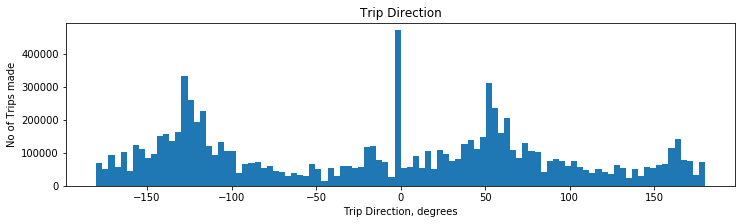

In [77]:
#Trip Direction
plt.figure(figsize=(12,3))
plt.title('Trip Direction')
plt.xlabel('Trip Direction, degrees')
plt.ylabel('No of Trips made')
plt.hist(data_merged['direction'], bins=100)
pass

I am building a model to predict future fare amounts and trip duration. In the future, I will not know the speed at which I will travel, so I will calculate the mean speed for each pickup and dropoff locations, week day, and hour. I will use this hourly mean as a proxy for future speed of the trip. 

In [78]:
#add mean speed by route, hour, weekday
speed=data_merged.groupby(['PULocationID','DOLocationID','week_day','hour'])['speed_mph'].mean().reset_index()
speed=speed.rename(columns={'speed_mph':'mean_speed'})
data_merged=pd.merge(data_merged,speed,how='left',on=['PULocationID','DOLocationID','week_day','hour'])


In [79]:
#Find wait time : minimum time between pickup and dropoffs
#will not run due to computational time
##for x in range(0,data_merged.shape[0]-1,1):
#    k=data_merged['DOLocationID'][x]
#    l=data_merged[data_merged['PULocationID']==k]['PU_time']
#    m=data_merged['DO_time'][x]
#    #minimum=abs(m-1).min().total_seconds()/60
#    minimum=abs(m-l).min().total_seconds()/60
#    data_merged['wait_time']=minimum



In [80]:
#from pandas.tseries.holiday import USFederalHolidayCalendar
#import datetime
#cal = USFederalHolidayCalendar()
#holidays = cal.holidays(start='2017-01-01', end='2017-12-31').to_pydatetime()
#week_dates = [ holidays - datetime.timedelta(days=i) for i in range(5) ]
#week_dates

In [81]:
data_merged=data_merged.drop(['flag','unknown_loc','tip_ratio','delta_lat','delta_lon'],axis=1)

# Model Setup

## Model Process

The objective of this case study is to maximize my income as a taxi driver driving ten extra hours a week. Since I am limited in the hours that I can drive, I cannot increase my income by increasing my driving time. Instead, I would maximize my income by maximizing the money earned per minute of my time working.

My main sources of money earned are fare amount and tip. Since tips are generally around 20% of the fare amount, this is a substantial amount of money that I must consider (impute where missing). My time working is the sum of time driving and time searching for passengers. It is worth noting that I would have a fuel cost as a function of distance driven as well as some fixed costs (taxi maintenance, taxi medallion, etc), which I will not consider in this problem.

As a taxi driver, I cannot dictate where my passengers will want to go or how long my trip will last, so my path is a series of conditional probabilities dependent upon where and where I start my day. (This is known as a Markov chain). My future rewards (money earned/time spent) are dependent upon what location I travel to and when I arrive at that location due to the fact that demand and travel time fluctuate with time.

If I had more time for this case study, my ultimate goal would be to build a Markov Decision process that optimizes my reward given two possible actions: picking up a passenger or searching for a trip due to low demand. I would calculate the probabilities of dropping off a passenger at each of the 263 locations after picking up at each of the 263 locations (probability matrix) for each hour using the results of a demand model. If the data was too sparse, I could cluster the locations based on geography or expand my time period. I would calculate the probability of a driver searching for a fare by applying the rule that if the average wait time at a location for that hour was greater than five minutes, the taxis that just dropped off a passenger would leave the location for a nearby location. The expected wait time could be calculated as the minimum absolute value of dropoff and pickup times.

I will build models to predict the two of the inputs of my Markov Decision Process: income (fare+tip) and duration.  

For the remainder of this case study, I will:
 * create the income targets (fare+tip amount)
 * explore the modeling attributes and their relationship with the targets
 * conduct feature selection and model hyperparameter tuning (in feature selection notebook)
 * review the model fits


## Create Tip Amount

Cash tips are not recorded. I want to include tips as part of my income. Since I only have tip information for credit card payments, I will impute the cash tips using the following logic:
    1. group trips by pickup location, drop off location, day of week, hour
    2. calculate the median tip ratio of credit card payments (tip/fare_amount)
    3. multiply the cash fare amount by the tip ratio
    4. round to the nearest dollar amount because I assume people paying cash do not want coin change
    

In [82]:
credit_card=data_merged.query('payment_type==1')[['PULocationID','DOLocationID','week_day','hour','fare_amount','tip_amount']]
credit_card['credit_tip_ratio']=credit_card['tip_amount']/credit_card['fare_amount']
credit_card=credit_card.groupby(['PULocationID','DOLocationID','week_day','hour']).agg({'credit_tip_ratio':'median'}).reset_index()


In [83]:
data_merged=pd.merge(data_merged,credit_card,how="left",on=['PULocationID','DOLocationID','week_day','hour'])
data_merged['credit_tip_ratio'].fillna(0.20,inplace=True)

In [84]:
data_merged['tip_impute']=np.where(data_merged['payment_type']==1,data_merged['tip_amount'],
                                   np.around(data_merged['fare_amount']*data_merged['credit_tip_ratio'],0))


In [85]:
data_merged['tip_impute'].describe()


count    9.330870e+06
mean     2.675615e+00
std      2.341276e+00
min      0.000000e+00
25%      1.260000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.700000e+01
Name: tip_impute, dtype: float64

In [86]:
#find total reward
data_merged['total_income']=data_merged['fare_amount']+data_merged['tip_impute']

In [87]:
train,test=train_test_split(data_merged,test_size=0.50,random_state=42)
#train.to_csv("data_train.csv")
#test.to_csv("data_test.csv")

In [88]:
#data_merged.to_csv("data_merged.csv")

## Univariate Analysis

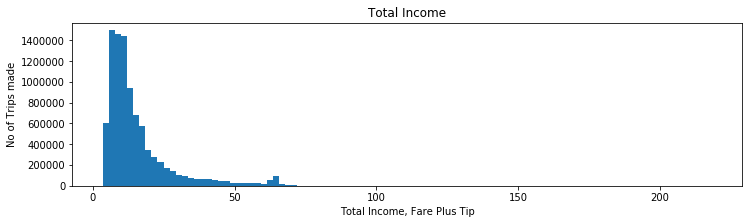

In [230]:
#Total Income - Model Target
plt.figure(figsize=(12,3))
plt.title('Total Income')
plt.xlabel('Total Income, Fare Plus Tip')
plt.ylabel('No of Trips made')
plt.hist(data_merged['total_income'], bins=100)
pass


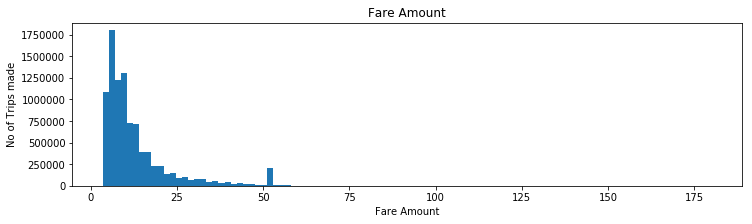

In [231]:
# Fare Amount
plt.figure(figsize=(12,3))
plt.title('Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('No of Trips made')
plt.hist(data_merged['fare_amount'], bins=100)
pass


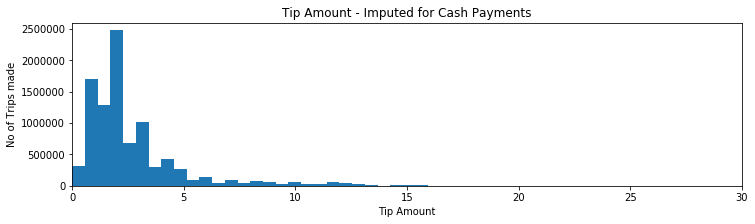

In [232]:
# Tip Impute
plt.figure(figsize=(12,3))
plt.title('Tip Amount - Imputed for Cash Payments')
plt.xlabel('Tip Amount')
plt.ylabel('No of Trips made')
plt.xlim(0,30)
plt.hist(data_merged['tip_impute'], bins=100)
pass


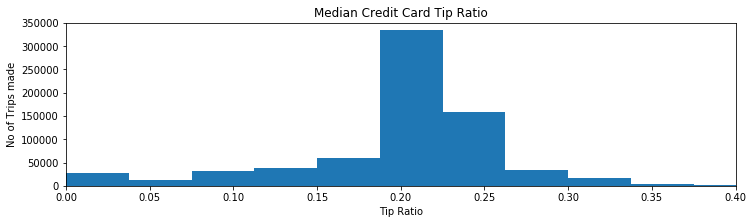

In [233]:
# Credit Card Tip Ratio
plt.figure(figsize=(12,3))
plt.title('Median Credit Card Tip Ratio')
plt.xlabel('Tip Ratio')
plt.ylabel('No of Trips made')
plt.xlim(0,0.4)
plt.hist(credit_card['credit_tip_ratio'], bins=100)
pass


Observations:
   * Total income has a smoother distribution than fare rate. This is due to the fact that the addition of the tip creates more unique values around \\$52, the flat fare for most airport trips
   * Almost all tips are less than \\$5
   * The median percentage of tips paid on credit card trips is skewed to the left and centered around 0.22. It was surprising to me that the majority of tips are between 20-25%
    

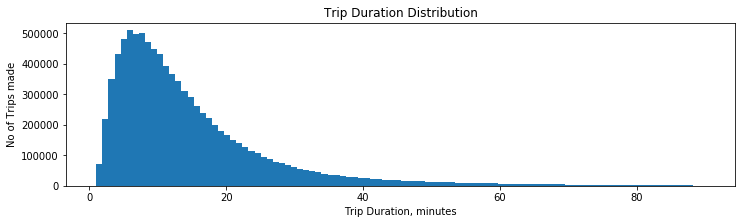

In [234]:
#Trip Duration
# trip duration distribution, minutes
plt.figure(figsize=(12,3))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('No of Trips made')
plt.hist(data_merged['duration_min'], bins=100)
pass



Observations: 
 * Even with outliers removed, the distriution of trip duration is still highly skewed to the right
 * The vast majority of trips lasted five to ten minutes

Observations: 
 * Even with outliers removed, the distriution of fare amounts are is still highly skewed to the right
 * The concentration of fares at \\$52 reflects the LGA and JFK flat fares
 * The vast majority of trips are under \\$25

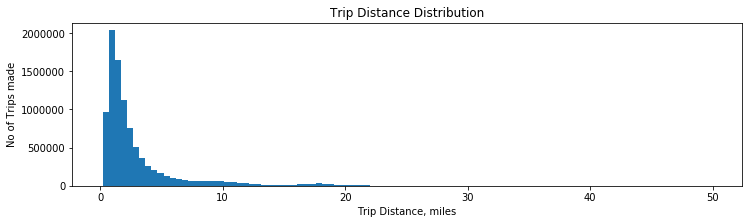

In [235]:
# Distance distribution, miles
plt.figure(figsize=(12,3))
plt.title('Trip Distance Distribution')
plt.xlabel('Trip Distance, miles')
plt.ylabel('No of Trips made')
plt.hist(data_merged['trip_distance'], bins=100)
pass



In [236]:
data_merged['trip_distance'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

0.00     0.20
0.01     0.33
0.10     0.68
0.25     1.00
0.50     1.70
0.75     3.10
0.90     6.85
0.95    10.70
0.99    18.70
1.00    49.90
Name: trip_distance, dtype: float64

Observations:
   * 90% of trips are under seven miles
   * There is a slight uptick in density around trip distances of 17-18 miles. This may be a popular route for airport trips

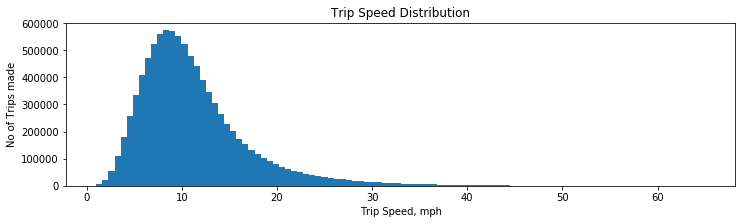

In [237]:
# Speed distribution
plt.figure(figsize=(12,3))
plt.title('Trip Speed Distribution')
plt.xlabel('Trip Speed, mph')
plt.ylabel('No of Trips made')
plt.hist(data_merged['speed_mph'], bins=100)
pass



In [238]:
data_merged['speed_mph'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

0.00     1.000219
0.01     3.025210
0.10     5.429929
0.25     7.357665
0.50    10.012739
0.75    13.565218
0.90    18.417527
0.95    22.478260
0.99    31.899485
1.00    64.990546
Name: speed_mph, dtype: float64

Observations:
   * Half of all trips are 10 mph or under
   * The right skew is probably due to airport trips and very short, quick trips

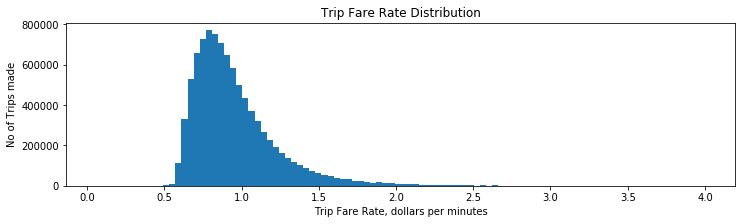

In [239]:
# Trip Fare Rate (dollars per minute)
plt.figure(figsize=(12,3))
plt.title('Trip Fare Rate Distribution')
plt.xlabel('Trip Fare Rate, dollars per minutes')
plt.ylabel('No of Trips made')
plt.hist(data_merged['dollar_per_min'], bins=100)
pass



In [240]:
data_merged['dollar_per_min'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

0.00    0.059787
0.01    0.604027
0.10    0.686368
0.25    0.766208
0.50    0.890411
0.75    1.067194
0.90    1.303258
0.95    1.489362
0.99    1.967213
1.00    4.000000
Name: dollar_per_min, dtype: float64

Observations:
   * 75% of trips have a fare rate of \\$1 or less. This corresponds to 2/5 miles per minute or 24 mph (without fees or waiting time)
   * As seen above, airport trips tend to generate a higher trip fare rate

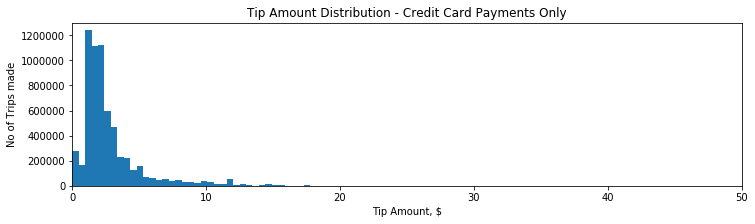

In [241]:
# Tip Distribution
#filter on payments that were made with a credit card because those are the only payment types that have recorded tips. Cash tips are not recorded
df=data_merged.query('payment_type==1')
plt.figure(figsize=(12,3))
plt.title('Tip Amount Distribution - Credit Card Payments Only')
plt.xlabel('Tip Amount, $')
plt.ylabel('No of Trips made')
plt.xlim(0,50)
plt.hist(df['tip_amount'], bins=100)
pass


In [242]:
df=data_merged.query('payment_type==1')
print("Distribution of Credit Card Tips")
df['tip_amount'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

Distribution of Credit Card Tips


0.00     0.00
0.01     0.00
0.10     1.00
0.25     1.36
0.50     2.00
0.75     3.06
0.90     5.19
0.95     8.00
0.99    12.21
1.00    48.05
Name: tip_amount, dtype: float64

Observations:
   * 99 percent of all tips are under \\$12

In [248]:
print("Distribution of Toll Amount Tips")
data_merged['tolls_amount'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

Distribution of Toll Amount Tips


0.00      0.00
0.01      0.00
0.10      0.00
0.25      0.00
0.50      0.00
0.75      0.00
0.90      0.00
0.95      5.76
0.99      5.76
1.00    933.50
Name: tolls_amount, dtype: float64

In [249]:
print("Distribution of MTA Tax Amount")
data_merged['mta_tax'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

Distribution of MTA Tax Amount


0.00    0.00
0.01    0.50
0.10    0.50
0.25    0.50
0.50    0.50
0.75    0.50
0.90    0.50
0.95    0.50
0.99    0.50
1.00    0.85
Name: mta_tax, dtype: float64

In [250]:
print("Distribution of Extra Fare Fees")
data_merged['extra'].quantile([0,0.01,0.1,0.25,0.5,0.75,0.90,0.95,0.99,1])

Distribution of Extra Fare Fees


0.00    0.0
0.01    0.0
0.10    0.0
0.25    0.0
0.50    0.0
0.75    0.5
0.90    1.0
0.95    1.0
0.99    1.0
1.00    4.8
Name: extra, dtype: float64

Oberservation:
   * The max toll amount of \\$933 is invalid. I will filter this record out of my data.
   * The MTA tax amount is reasonable
   * The extra fare amount is reasonable 

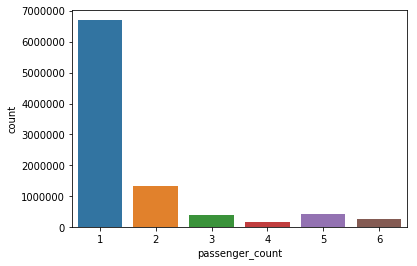

In [251]:
#Passenger Count
sns.countplot(data_merged.passenger_count)
plt.show()



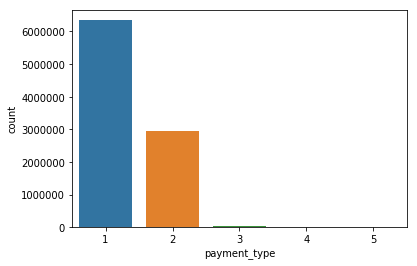

In [252]:
#Payment Type
sns.countplot(data_merged.payment_type)
plt.show()

In [253]:
df=data_merged.groupby(['payment_type'])['payment_type'].count().sort_values(ascending=False)
df=pd.DataFrame(df)
df=df.rename(columns={'payment_type':'counts'})
df['counts'].astype('int64')
df['percent']=(df['counts']/data_merged.shape[0])*100
print("Trip Counts and Percent of Trips by Payment Type")
df

Trip Counts and Percent of Trips by Payment Type


,counts,percent
payment_type,,
1,6341275,67.960169
2,2944745,31.559169
3,33541,0.359463
4,11308,0.121189
5,1,0.000011


About 2/3 of payments are using credit cards and 1/3 of payments are using cash. The data cleaning has eliminated all voided trips (payment type 6).

In [282]:
#Store and forward
data_merged.groupby(['store_and_fwd_flag'])['store_and_fwd_flag'].count()

store_and_fwd_flag
N    9300906
Y      29964
Name: store_and_fwd_flag, dtype: int64

In [283]:
#Store and forward - mean income
data_merged.groupby(['store_and_fwd_flag'])['total_income'].mean()

store_and_fwd_flag
N    15.643149
Y    16.901390
Name: total_income, dtype: float64

In [415]:
#Store and forward - mean duration
data_merged.groupby(['store_and_fwd_flag'])['duration_min'].mean()

store_and_fwd_flag
N    14.802993
Y    16.354717
Name: duration_min, dtype: float32

There are very few records with the store_and_fwd_flag. The mean total income is similar between these two fields. The store and forward flag has a slightly higher duration. This could be due to taxis traveling farther to areas and lose connectivity. 

In [254]:
#Ratecode ID
data_merged.groupby(['RatecodeID'])['RatecodeID'].count()



RatecodeID
1    9115031
2     195521
3      17687
4        360
5       2269
6          2
Name: RatecodeID, dtype: int64

Observations:
   * 1 = Standard Rate
   * 2 = JFK
   * 3 = Newark
   * 4 = Nassau or Westchester
   * 5 = Negotiated fare
   * 6 = Group Ride

There are only two group rides in this data set. This is probably due to filtering out trips with high passenger count. I also do not know where LGA trips are classified. 

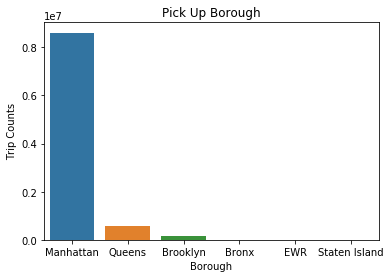

In [413]:
sns.countplot(data_merged.Borough_PU)
plt.title("Pick Up Borough")
plt.ylabel('Trip Counts')
plt.xlabel('Borough')
plt.show()

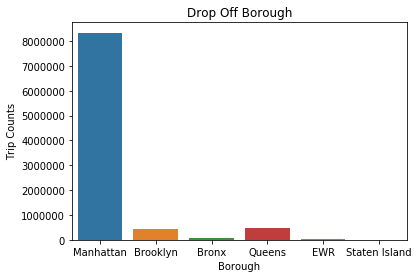

In [414]:
sns.countplot(data_merged.Borough_DO)
plt.title("Drop Off Borough")
plt.ylabel('Trip Counts')
plt.xlabel('Borough')
plt.show()

In [255]:
# Aiport Indicator - feature created by me
df=data_merged.groupby(['Airport_Ind'])['Airport_Ind'].count().sort_values(ascending=False)
df=pd.DataFrame(df)
df=df.rename(columns={'Airport_Ind':'counts'})
df['counts'].astype('int64')
df['percent']=(df['counts']/data_merged.shape[0])*100
print("Trip Counts and Percent of Trips by Airport Classification")
df

Trip Counts and Percent of Trips by Airport Classification


,counts,percent
Airport_Ind,,
None,8657048,92.778573
LGA,377165,4.042120
JFK,279036,2.990461
EWR,17621,0.188846


Observations:
   * There are 279,000 trips to and from JFK, but there are only 195,000 trips with the rate code of 2. The rate code must only capture trips to and from JFK from certain locations
   * There are 10,000 more trips to and from LGA than JFK. LGA is closer to Manhattan than JFK
   * From my previous analysis, I noticed that Newark has a higher trip fare amount and fare rate than the other airports, but the trip volume is significantly less than JFK and LGA
   * Airport trips comprise about 7% of all trips
   

In [256]:
#Improvement surcharge
df=data_merged.groupby(['improvement_surcharge'])['improvement_surcharge'].count().sort_values(ascending=False)
df=pd.DataFrame(df)
df=df.rename(columns={'improvement_surcharge':'counts'})
df

,counts
improvement_surcharge,
0.3,9329865
0.0,1005


As seen above, there are only a few trips with no improvement surcharge. Since this is a charge that is charged to all trips, the 0 values are erroneous. This attribute has no predictive power due to it being essentially a constant.


In [257]:
#Precipitation - an feature engineered by me
print("Hourly Precipitation (inches)")
data_merged['precip_inch'].quantile([0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,1])



Hourly Precipitation (inches)


0.01    0.00
0.10    0.00
0.25    0.00
0.50    0.00
0.75    0.00
0.90    0.00
0.95    0.01
0.99    0.52
1.00    2.20
Name: precip_inch, dtype: float64

In [258]:
#Hourly Temperature - an feature engineered by me
print("Hourly Temperature Farenheit")
data_merged['tmpf'].quantile([0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,1])



Hourly Temperature Farenheit


0.01    53.1
0.10    61.0
0.25    66.9
0.50    73.9
0.75    80.1
0.90    84.0
0.95    88.0
0.99    91.9
1.00    93.9
Name: tmpf, dtype: float64

In [259]:
#Relative Humidity - an feature engineered by me
print("Hourly Relative Humidity")
data_merged['relh'].quantile([0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,1])



Hourly Relative Humidity


0.01    29.750000
0.10    37.290000
0.25    42.490000
0.50    56.300000
0.75    75.750000
0.90    90.050000
0.95    93.400000
0.99    96.646667
1.00    97.727500
Name: relh, dtype: float64

Observations:
   * There were very few observations with rain
   * My theory is that demand may increase when the temperature and humidity are high. That being said, late June is more likely to be hot and humid, which also corresponds to the weekend before the Forth of July holiday. This interaction with the holiday may disguise the impact of weather on demand.

    

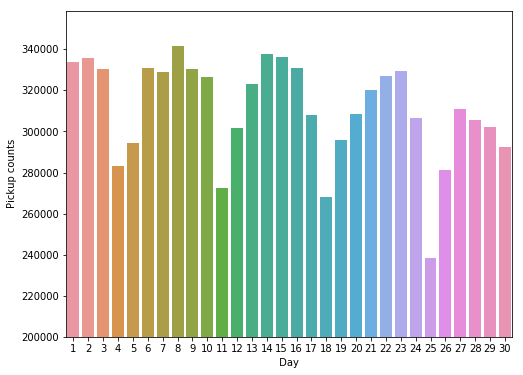

Trip Counts by Day in June 2017


In [260]:
plt.figure(figsize = (8,6))
sns.countplot(data_merged.day)
plt.xlabel(' Day ')
plt.ylabel('Pickup counts')
plt.ylim(200000,)
plt.title("Trip Counts by Day in June 2017")
plt.show()

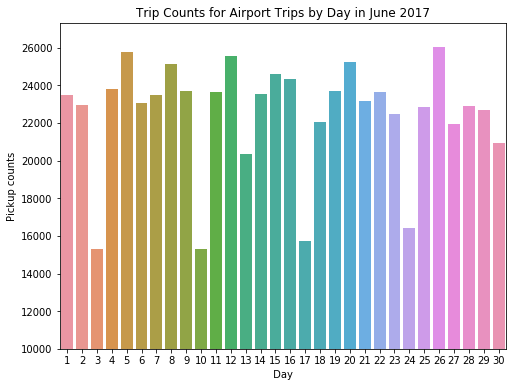

In [177]:
data=data_merged.query('airport_flag==0')
plt.figure(figsize = (8,6))
sns.countplot(data.day)
plt.xlabel(' Day ')
plt.ylabel('Pickup counts')
plt.ylim(10000,)
plt.title("Trip Counts for Airport Trips by Day in June 2017")
plt.show()
del data

Observations:
   * There is a slight decline in trip count as the month of June 2017 progresses. I suspected that this was due to the fact that people were going on vacation for Fourth of July
   * Trips to and from the airport have a more stable pattern. I expected an uptick in airport trips towards the end of the month, but there was none. June 5,12,20, and 26 were the highest volume days for airport trips. These dates correspond to Mondays and Tuesdays. 

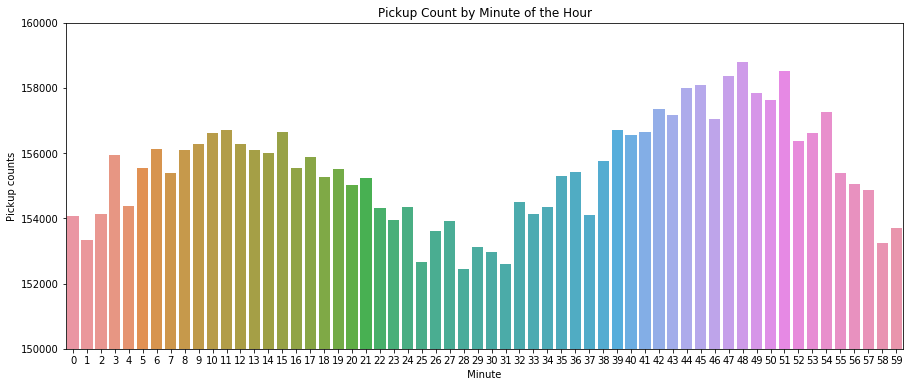

In [269]:
plt.figure(figsize = (15,6))
sns.countplot(data_merged.minute)
plt.xlabel(' Minute ')
plt.ylabel('Pickup counts')
plt.ylim(150000,160000)
plt.title("Pickup Count by Minute of the Hour")
plt.show()

Observations:
   * There is not that much difference in pickup counts across the minutes of the hour, but there is a slight peak in pickup counts around 10 minutes into the hour and 45 minutes into the hour. The beginning of the hour, halfway mark (30 minutes), and end of the hour have the least number of pickups.
   * I wonder if this demand has to do with subway schedules or shift work. 

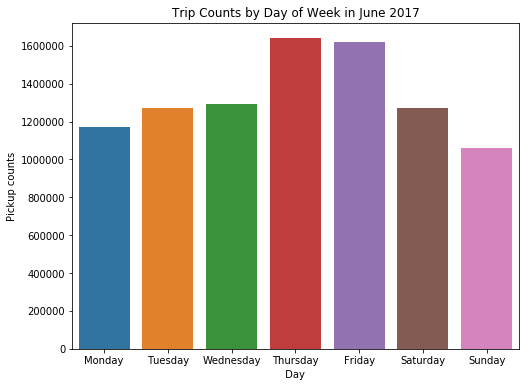

In [261]:
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
sorterIndex

df = data_merged.groupby(['week_day'])['week_day'].count()
df=pd.DataFrame(df)
df['Day_id'] = df.index
df['Day_id'] = df['Day_id'].map(sorterIndex)
df.sort_values('Day_id', inplace=True)
df=df.rename(columns={'week_day':'counts'})
df['week_name']=df.index

#fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
#ax.bar(df.Day_id, df.Sales)
#ax.set_xticks([x+0.4 for x in df.Day_id])
#ax.set_xticklabels(df.index)
#ax.set_axis_bgcolor('white')

plt.figure(figsize = (8,6))
ax = sns.barplot(x="week_name", y="counts",data=df)
#sns.countplot(df.week_day)
plt.xlabel(' Day ')
plt.ylabel('Pickup counts')
plt.title('Trip Counts by Day of Week in June 2017')
plt.show()

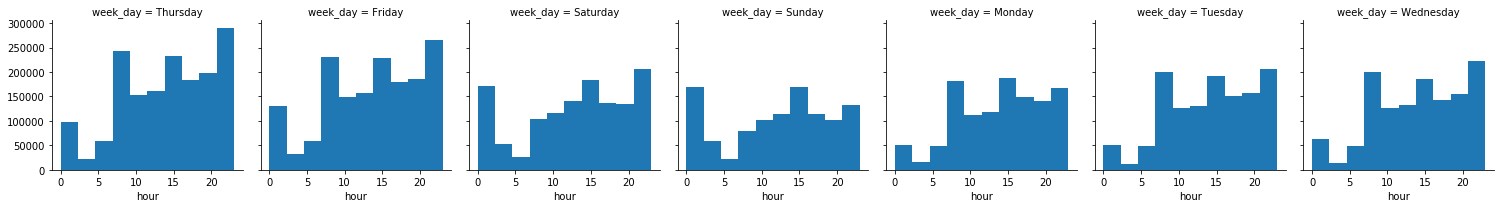

In [262]:
#Trips by hour
n = sns.FacetGrid(data_merged, col='week_day')
n.map(plt.hist, 'hour')
plt.show()



Observations:
   * Trip volume is highest on Thursdays and Fridays. The afternoon and evening traffic is especially heavy.
   * Early morning trip volume spikes on Saturday and Sunday, although Thursday and Friday have a significant early volume traffice as well
   * 3-5 am is the lowest demand period during the week. 5-6 am is the lowest demand period during the weekend.

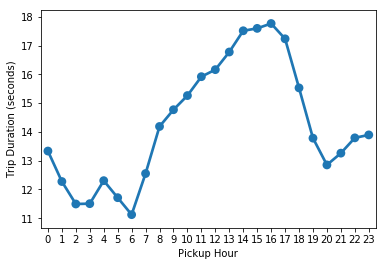

In [263]:
df = data_merged.groupby('hour').duration_min.mean()
sns.pointplot(df.index, df.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

Observations:
   * Trip duration steadily increases from 6 am to 5 pm. It rapidly decreases from 5 pm to 10 pm before increasing again. This corresponds with the trip counts. Duration is almost perfectly correlated with demand since demand creates traffic.  

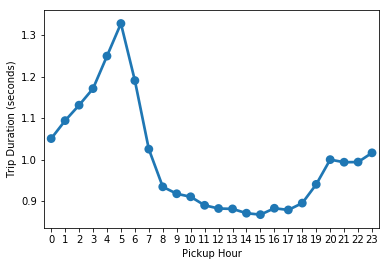

In [123]:
df = data_merged.groupby('hour').speed_mph.mean()
sns.pointplot(df.index, df.values)
plt.ylabel('Mean Rate Per Minute')
plt.xlabel('Pickup Hour')
plt.show()


Observations:
   * The mean rate per minute spikes at 5 am, which is the lowest period of demand.
   * The mean rate per minute is negatively coorelated with demand/traffic.

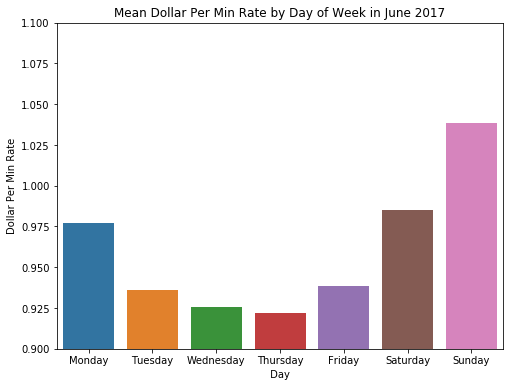

In [128]:
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
sorterIndex

df = data_merged.groupby(['week_day'])['dollar_per_min'].mean()
df=pd.DataFrame(df)
df['Day_id'] = df.index
df['Day_id'] = df['Day_id'].map(sorterIndex)
df.sort_values('Day_id', inplace=True)
df=df.rename(columns={'week_day':'counts'})
df['week_name']=df.index

plt.figure(figsize = (8,6))
ax = sns.barplot(x="week_name", y="dollar_per_min",data=df)
#sns.countplot(df.week_day)
plt.xlabel(' Day ')
plt.ylabel('Dollar Per Min Rate')
plt.title('Mean Dollar Per Min Rate by Day of Week in June 2017')
plt.ylim(0.90,1.10)
plt.show()


Observations:
   * Dollar per minute (rate) is negatively correlated with demand (trip count); the rate is higher for days that have low demand probably due to less traffic
    

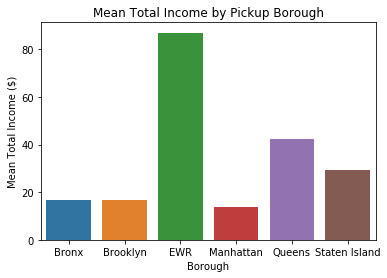

In [417]:
df = data_merged.groupby('Borough_PU').total_income.mean()
sns.barplot(df.index, df.values)
plt.title('Mean Total Income by Pickup Borough')
plt.ylabel('Mean Total Income ($)')
plt.xlabel('Borough')
plt.show()

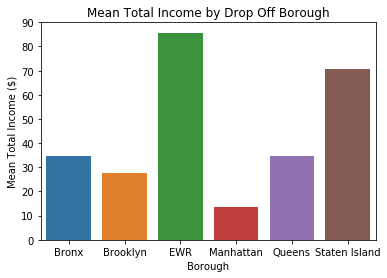

In [419]:
df = data_merged.groupby('Borough_DO').total_income.mean()
sns.barplot(df.index, df.values)
plt.title('Mean Total Income by Drop Off Borough')
plt.ylabel('Mean Total Income ($)')
plt.xlabel('Borough')
plt.show()

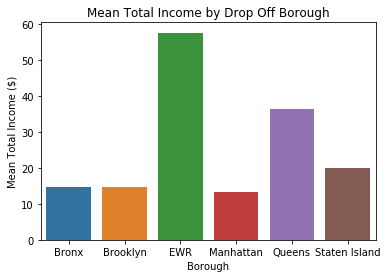

In [421]:
df = data_merged.groupby('Borough_PU').duration_min.mean()
sns.barplot(df.index, df.values)
plt.title('Mean Duration by Drop Off Borough')
plt.ylabel('Mean Trip Duration (minutes)')
plt.xlabel('Borough')
plt.show()

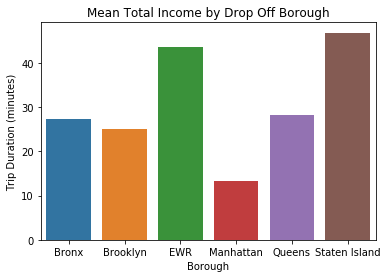

In [423]:
df = data_merged.groupby('Borough_DO').duration_min.mean()
sns.barplot(df.index, df.values)
plt.title('Mean Total Income by Drop Off Borough')
plt.ylabel('Trip Duration (minutes)')
plt.xlabel('Borough')
plt.show()

Although the Boroughs are corellated with latitude and longitude information, I will keep these attributes in the model for feature selection.

## The Models

## Feature Selection

Due to memory issues and processing time, I conducted my feature selection in a separate notebook. Please refer to the feature selection notebook for my correlation analysis, hyparameter tuning, and feature importance ranking.

When selecting features, I use all or most of the following techniques:
    * review univariates of features
    * calculate the kendalls tau or spearmans rho between features to find highly correlated clusters
    * calculate the lift statistics of attributes such as their ks, gini, and mutual information values with respect to the target
    * run a lasso regression to get an initial list of features to drop
    * run various machine learning techniques for feature importance ranking, such as extratrees, boruta with extratrees base, rfe with extratrees or random forest model, and gbm with shallow trees
    * review shapley values (if run time permits)
    

## Predict Income (Fare + Tip) 

As stated in my feature selection notebook, I will remove the following attributes:

I will drop the PULocationID and DOLocationID in favor of latitude and longitude. The ID values are somewhat haphazardly assigned where as latitude and longitude reflect a geospatial relationship between the various pickup and dropoff points.

I will drop the extra amount, mta tax, and improvement surcharge due to lack of unique values and inherient predictive power.

The tip amount, imputed tip amount,total amount, and fare amount are already components of the total_income model target.

My feature selection algorithm also revealed that month number and borough classifications of pickup and dropoff locations were not important. This is due to the fact that the month number is a constant (only one month of data) and the pickup and dropoff locations are captured in the latitude and longitude values. 

In [105]:
data_model=data_merged.drop(['PULocationID','DOLocationID','extra','mta_tax','tip_amount',
                             'fare_amount','total_amount','improvement_surcharge','tip_impute','dollar_per_min',
                            'direct_distance','PU_time','DO_time','speed_mph','Borough_PU',
                            'Zone_PU','service_zone_PU','Borough_DO','Zone_DO','service_zone_DO','airport_flag','month'],axis=1)

In [106]:
#convert the store and forward Y and N values to an indicator
data_model['store_and_fwd_ind']=np.where(data_model['store_and_fwd_flag']=="Y",1,0)
data_model=data_model.drop(['store_and_fwd_flag'],axis=1)

data_model['Airport_Ind']=data_model['Airport_Ind'].astype('category')
data_model['week_day']=data_model['week_day'].astype('category')


In [107]:
#split the data for train and validation of model - 2/3 train and 1/3 validation
from sklearn.model_selection import train_test_split
train,val = train_test_split(data_model,test_size=0.33,random_state=42)


In [108]:
#prepare targets
X_train=train.drop(['total_income','duration_min'],axis=1)
Y_income_train=train['total_income']
Y_duration_train=train['duration_min']

X_val=val.drop(['total_income','duration_min'],axis=1)
Y_income_val=val['total_income'] 
Y_duration_val=val['duration_min']

In [111]:
#create a tunning for feature selection
import lightgbm as lgbm
eval_set=[(X_val,Y_income_val)]
metric="rmse"
income_model=lgbm.LGBMRegressor(
                         learning_rate=0.1,
                         n_estimators=1500,
                         max_depth=10,
                         bagging_fraction=0.66,
                         reg_alpha=10,
                         reg_lambda=1,
                        )

In [112]:
income_results=income_model.fit(X_train,Y_income_train)

In [114]:
y_pred_train=income_results.predict(X_train,type="response")
y_pred_val = income_results.predict(X_val,type="response")

In [115]:
from sklearn import metrics
print(metrics.r2_score(Y_income_train,y_pred_train))
print(metrics.r2_score(Y_income_val,y_pred_val))
print(metrics.mean_absolute_error(Y_income_train,y_pred_train))
print(metrics.mean_absolute_error(Y_income_val,y_pred_val))
print(metrics.median_absolute_error(Y_income_train,y_pred_train))
print(metrics.median_absolute_error(Y_income_val,y_pred_val))

0.9755775775602897
0.9746423849924648
1.2923055264834629
1.3016831130040993
0.8638805636847566
0.8672155372404013


In [116]:
from joblib import dump, load
dump(income_results, 'income_prediction_model.joblib') 

['income_prediction_model.joblib']

In [125]:
#create a tunning for feature selection
import lightgbm as lgbm
metric="rmse"
duration_model=lgbm.LGBMRegressor(
                         learning_rate=0.1,
                         n_estimators=1500,
                         max_depth=12,
                         bagging_fraction=0.66,
                         reg_alpha=10,
                         reg_lambda=1
                        )

In [126]:
duration_results=duration_model.fit(X_train,Y_duration_train)

In [127]:
y_pred_train=duration_results.predict(X_train,type="response")
y_pred_val = duration_results.predict(X_val,type="response")

In [128]:
from sklearn import metrics
print(metrics.r2_score(Y_income_train,y_pred_train))
print(metrics.r2_score(Y_income_val,y_pred_val))
print(metrics.mean_absolute_error(Y_income_train,y_pred_train))
print(metrics.mean_absolute_error(Y_income_val,y_pred_val))
print(metrics.median_absolute_error(Y_income_train,y_pred_train))
print(metrics.median_absolute_error(Y_income_val,y_pred_val))

0.8240145363351705
0.8246095192645903
3.013316611531431
3.0104591889892536
1.8467018817544414
1.8466744476028563


In [129]:
from joblib import dump, load
dump(duration_results, 'duration_prediction_model.joblib') 

['duration_prediction_model.joblib']

Concluding Remarks:
    
    Both the income and duration models had desirable r squared values and minimum change in error between train and validation. I noticed that the early stopping rounds were not triggered for my current number of trees, 1500, but they were triggered at around iteration 1900. Increasing the number of trees to 2000 would increase the accuracy of the predictions, but it would increase fit time and possibly lead to overfitting.
    
    I would like to continue my modeling on a full year of data. This would allow me to capture the time series component of the taxi pricing, demand, and duration. I would also like to incorporate the attributes listed below.
    
    The intention of my models is to predict income and duration for inputs into a MDP model. I wanted to be able to predict future income, duration, and demand instead of using historical data, which is what is normally used in Q-Learning algorithmns.
    


## Additional Data to be Considered in Future Models:

### Factors influencing demand:
* Location of subway stations and other transit hubs
* Uber volume
* Citibike usage/locations
* Special events in NYC (parades, marathons, festivals, sports events, concerts, etc)
* Cash tip amounts
* Location of bars, restaurants, points of interest (museums, tourist attractions, etc)
* Bank holidays
* Parking lot locations (can indicate higher density of car ownership), car ownership density
* Population density
* Job density
* Major storm events
* Population demographics for area (job type, age, income) 


### Factors influencing trip time:
* Speed limit on roads
* Average observed speed on roads
* Type of road/road classification
* Pavement quality
* Road closures and construction zones
* Other construction, such as construction at LGA
* Driving visability (foggy conditions, line-of-sight distances)
* Driveway desnity
* Traffic collisions and other incidents
* Traffic volume on roads
* Intersection density
* Presence of shoulder on road

### Factors for better model target:
* Cash tip amounts
* Taxi id numbers (for tracking trips and wait times)
* Parking lot locations (allow taxi to wait for future pickups)
* Wait times of taxi, search times of taxi
* Fuel prices (impact profitability)




# THANK YOU VERY MUCH FOR YOUR TIME!

For any questions, please contact Laura Evans at lfrisbie3@gmail.com